# 🐰 Easter with Rockpool 🥚

In [1]:
# - Imports
from rockpool import TSEvent, TSContinuous

import numpy as np
from tqdm.autonotebook import trange

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/Users/Shared/anaconda3/envs/py36_tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


We'll define a dataset class that encompasses the task of mapping frozen poisson inputs to RGB images. We'll define a number of input channels to receive the poissonian noise; the output of the network will be several spiking neurons per pixel column, encoding the red, green and blue components of an image pixel. The images will be encoded by stretching them out across time, so that some number of time steps corresponds to a pixel row.

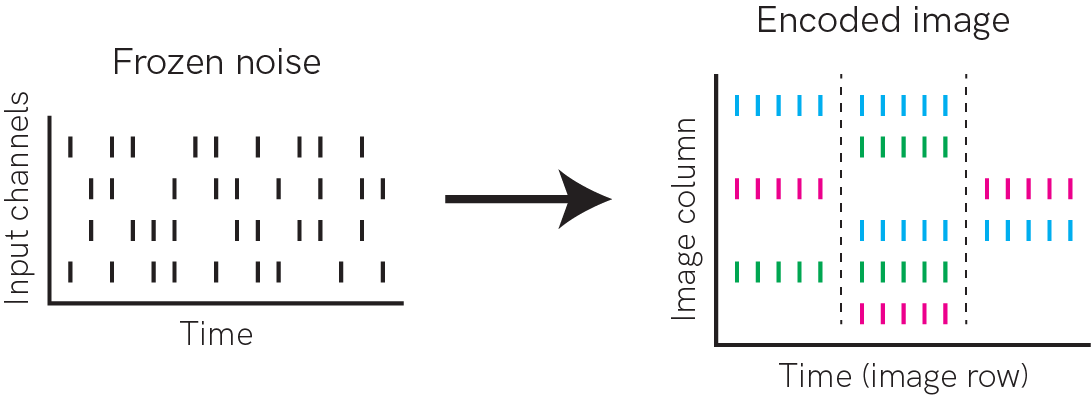

In [12]:
from IPython.display import Image
Image("task.png")

The dataset class will specify the task, and return samples for training and testing

In [13]:
# - Dataset
class PoissonToImages:
    def __init__(self, filenames: str,
                 num_input_channels: int,
                 num_output_channels_per_pixel: int,
                 time_steps_per_pixel: int = 10,
                 poisson_rate = 0.2,
                ):
        self.Nin = num_input_channels
        self.time_steps_per_pixel = time_steps_per_pixel
        self.num_output_channels_per_pixel = num_output_channels_per_pixel
        
        # - Read filenames in turn
        self.Nclasses = 0
        self.images = []
        for this_file in filenames:
            try:
                im = plt.imread(this_file)
                self.images.append(im)
                self.Nclasses += 1

            except:
                pass
            
        # - Generate poisson input and targets for classes
        self.input_raster = []
        self.target_raster = []
        for class_index in range(self.Nclasses):
            # - Generate output target raster for this class
            this_target = self.encode(self.images[class_index])
            self.target_raster.append(this_target)

            # - Generate poisson input raster for this class
            self.input_raster.append(np.random.rand(this_target.shape[0], num_input_channels) < poisson_rate)
            
            
        self.Nout = self.target_raster[-1].shape[1]
            
    def __getitem__(self, index):
        return self.input_raster[index], self.target_raster[index]
    
    def __len__(self):
        return self.Nclasses
    
    def quantize(self, image: np.ndarray) -> np.ndarray:
        im_quant = None
        
        if image.ndim == 2:
            # - Quantise down to `num_output_channels`
            num_levels = 2 ** num_output_channels_per_pixel
            im_quant = np.round(image * num_levels).astype('uint8')
            im_quant = np.unpackbits(im_quant, axis=2, bitorder = 'little')
            im_quant = im_quant[:, :, :num_output_channels]

        elif image.ndim == 3:
            # - Quanitise each RGB channel
            channels_per_RGB = int(np.floor((self.num_output_channels_per_pixel / 3)))
            num_levels = 2 ** channels_per_RGB-1
            image = np.round(image * num_levels).astype('uint8')

            im_quant = []
            for ch in range(3):
                this_ch = np.unpackbits(image[:, :, ch:ch+1], axis = 2, bitorder = 'little')
                im_quant.append(this_ch[:, :, :channels_per_RGB])

            im_quant = np.concatenate(im_quant, axis = 2)

        return im_quant
    
    def encode(self, image):
        target = np.expand_dims(self.quantize(image), axis=1)
        target = np.repeat(target, self.time_steps_per_pixel, axis=1)
        target = np.reshape(target, (image.shape[0] * self.time_steps_per_pixel, -1))
        return target
    
    def decode(self, output, class_index):
        output = np.reshape(output, (self.images[class_index].shape[0], self.time_steps_per_pixel, self.images[class_index].shape[1], -1 ))
        output = np.mean(output, axis = 1)
        return output

Now we can load some image files and generate a task and dataset. We'll use 1000 input channels, and a single R, G and B output channel per pixel column.

Dataset: Loaded 3 images.


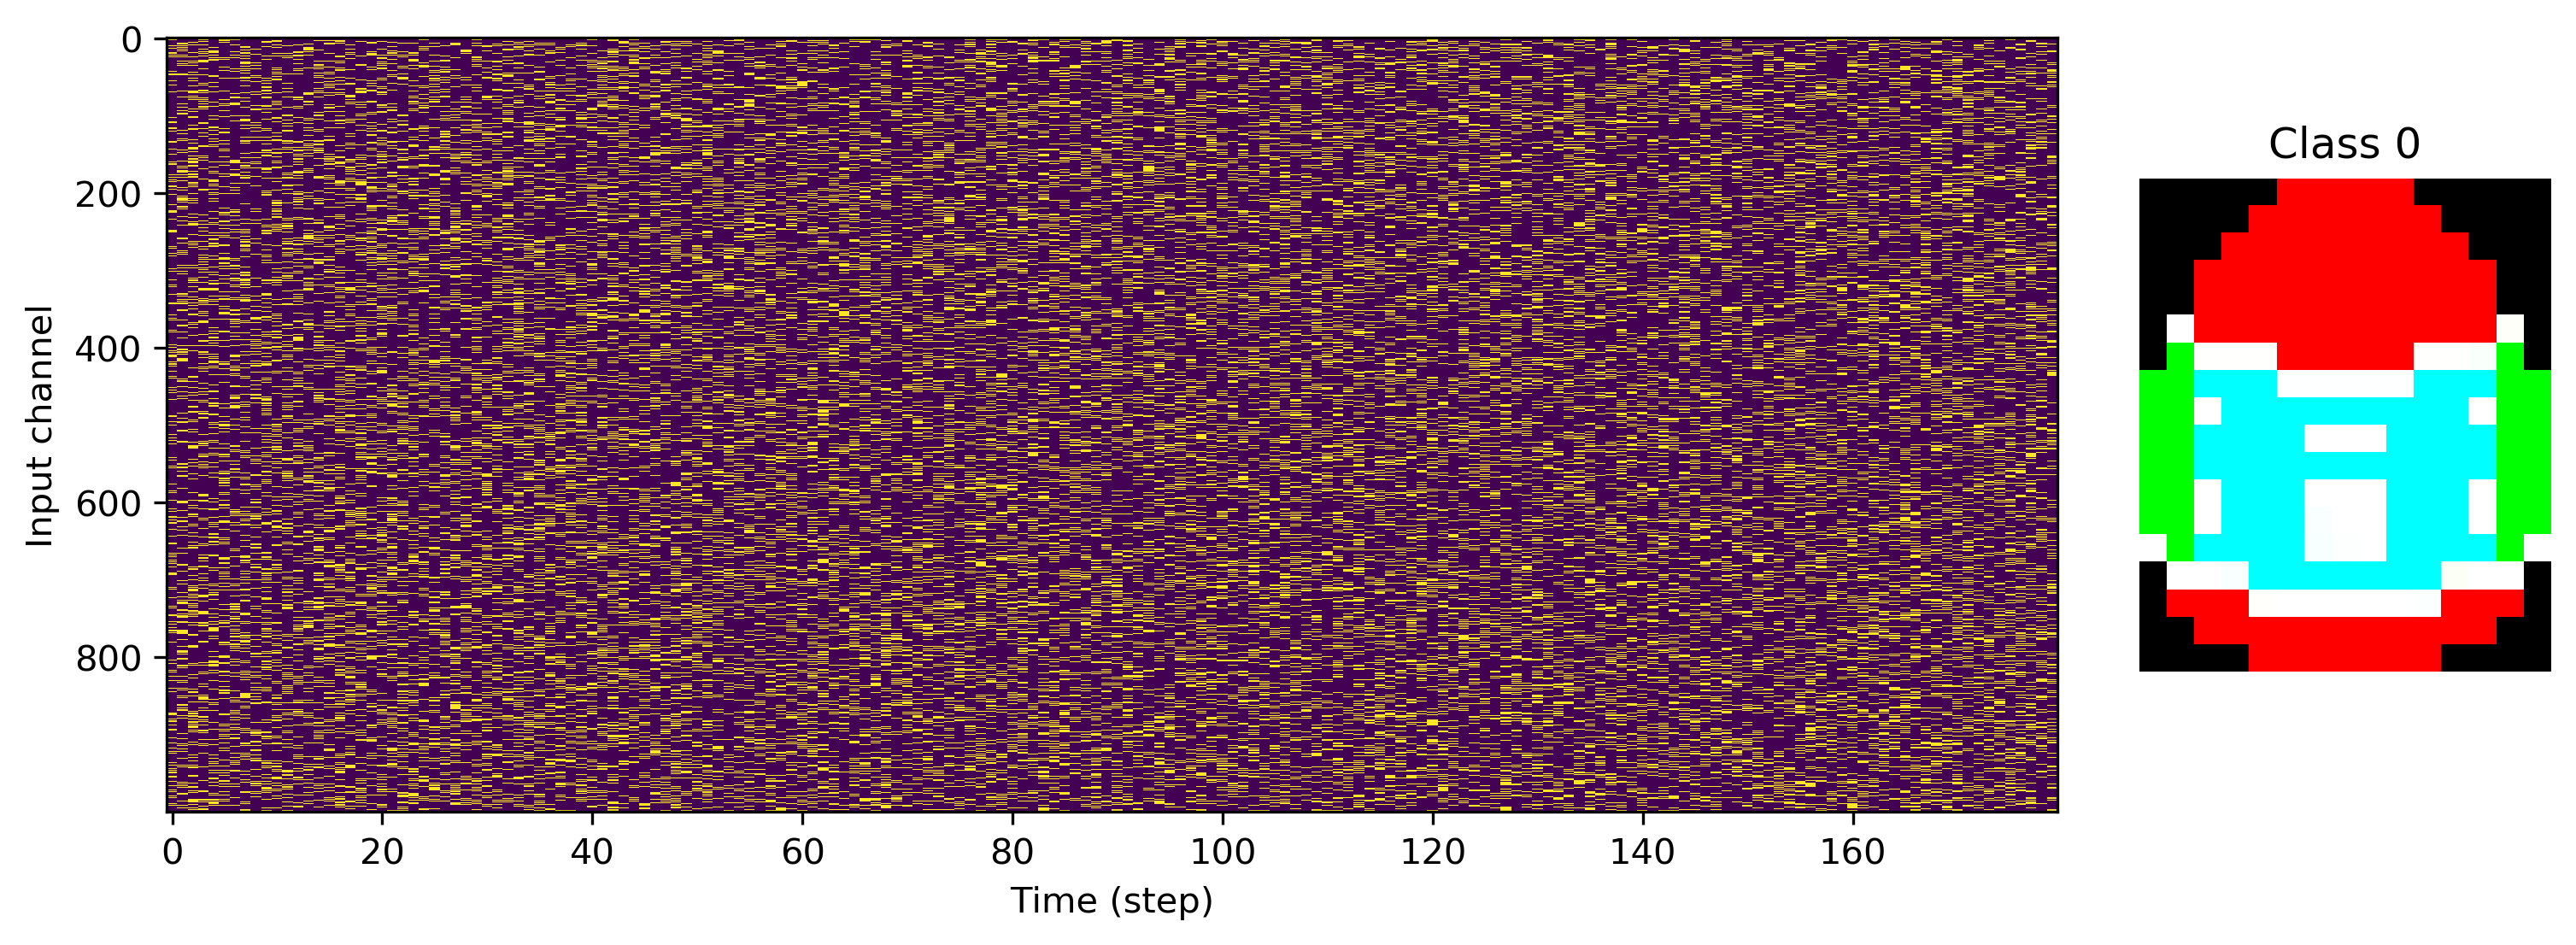

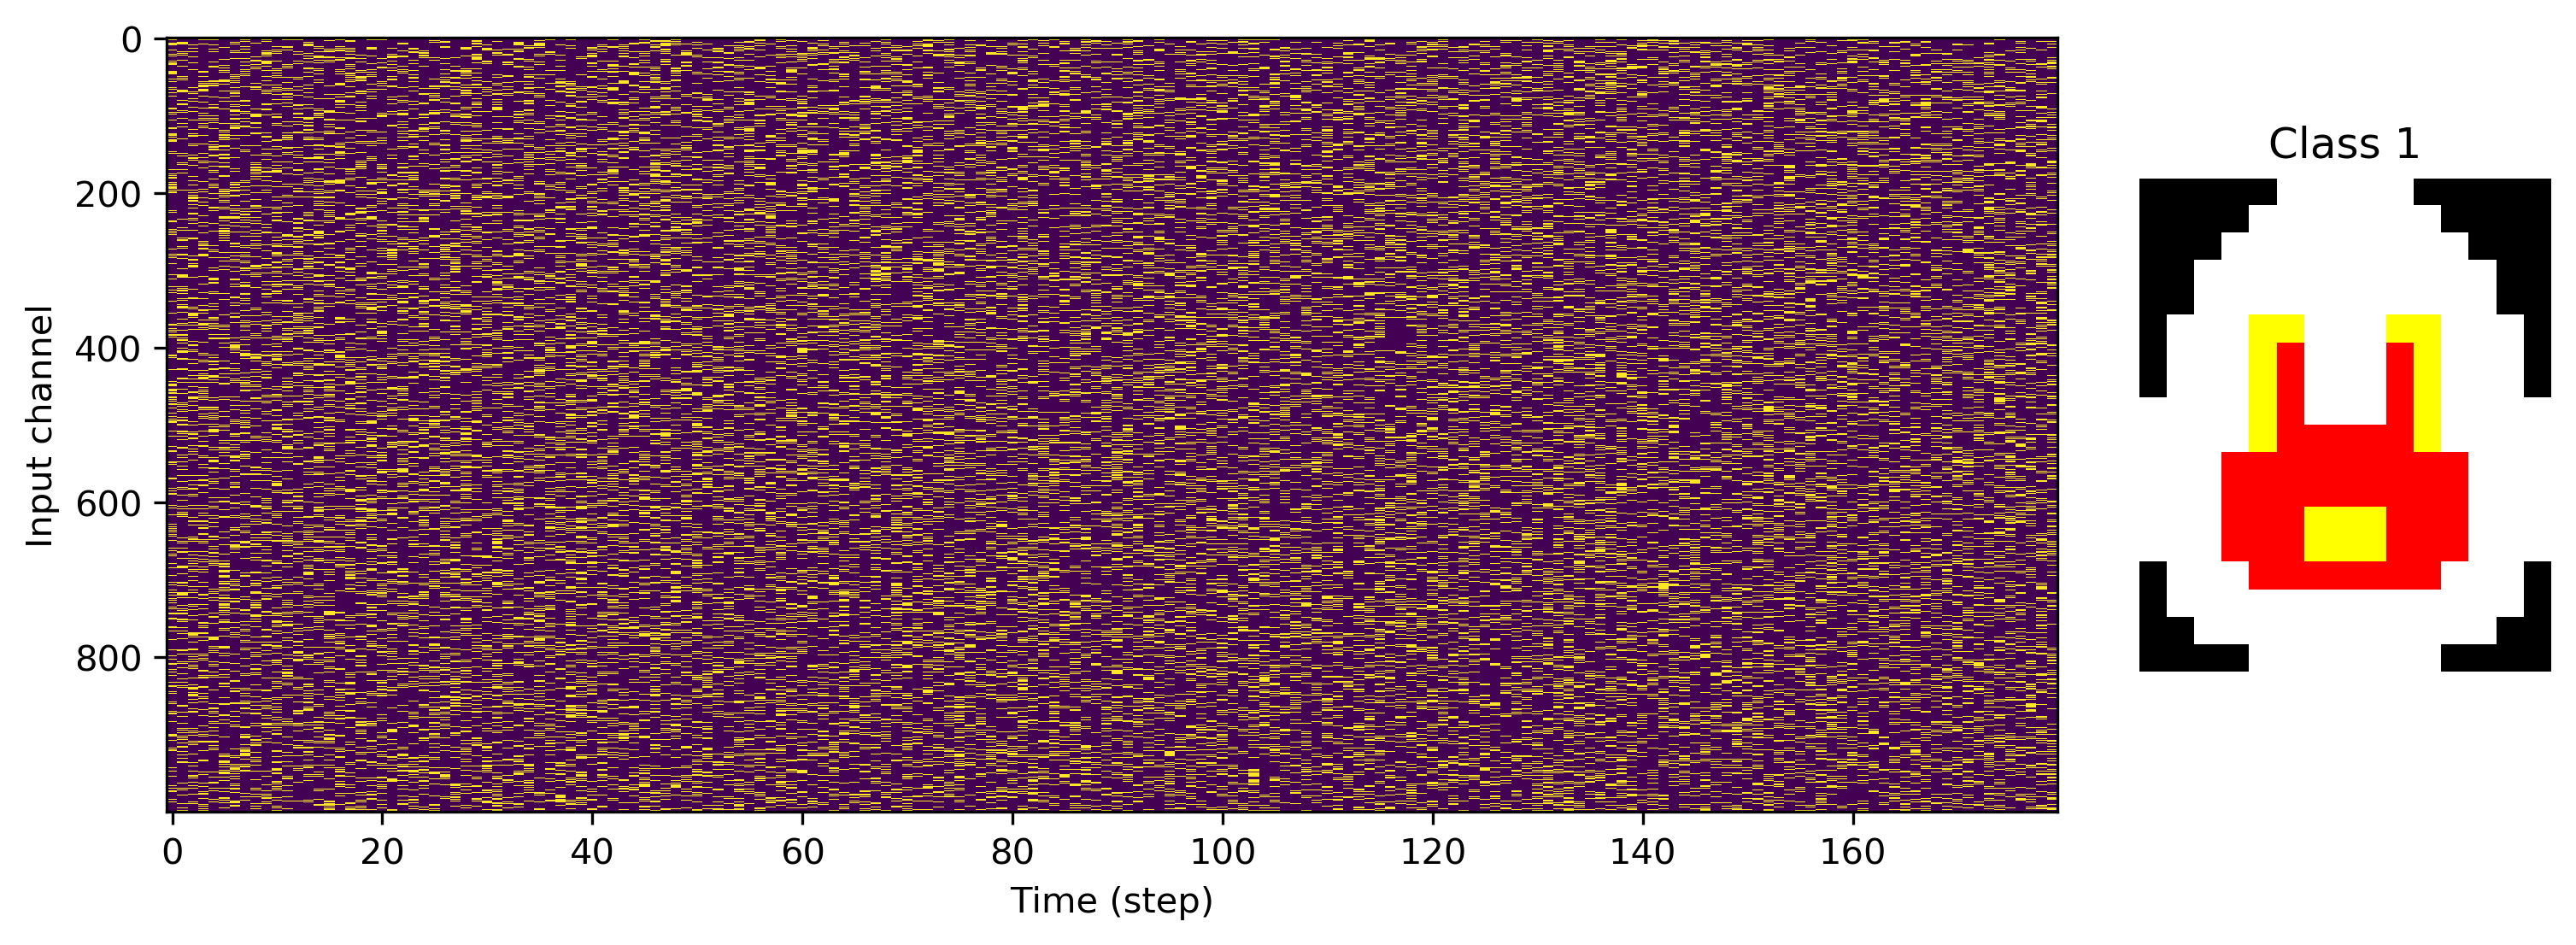

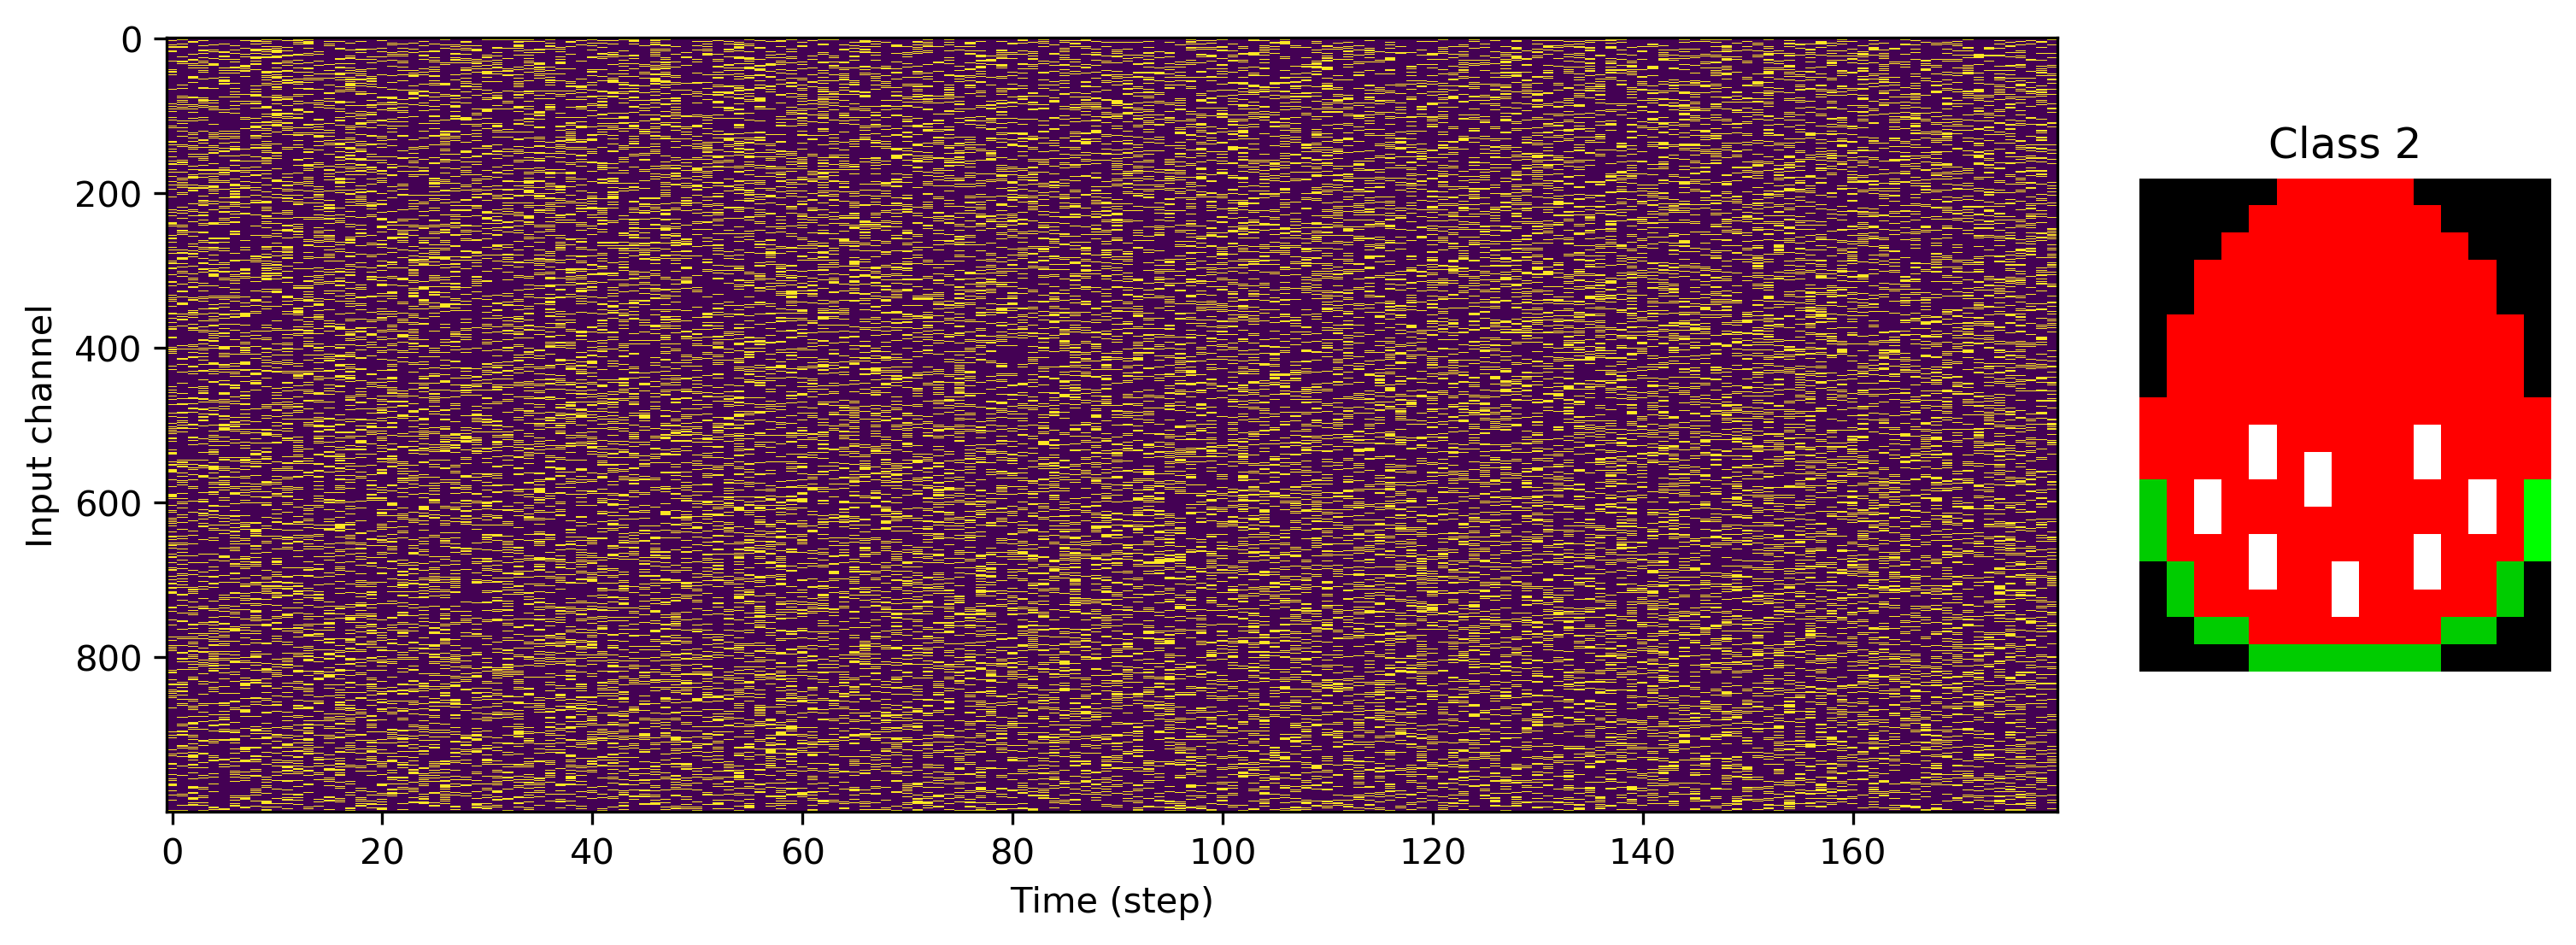

In [15]:
# - Task configuration
Nin = 1000
Nout_per_pix = 3

# - Load a data set and visualise
ds = PoissonToImages(['egg-1.png',
                      'egg-2.png',
                      'egg-3.png',],
                     Nin,
                     Nout_per_pix,
                    )
print(f'Dataset: Loaded {len(ds)} images.')

for class_index in range(len(ds)):
    plt.figure()
    plt.subplot(1, 5, (1, 4))
    plt.imshow(ds.input_raster[class_index].T, aspect='auto')
    plt.xlabel('Time (step)')
    plt.ylabel('Input channel')
    
    plt.subplot(1, 5, 5)
    plt.imshow(ds.images[class_index].astype('float'))
    plt.axis('off')
    plt.title(f'Class {class_index}')

We can also see exactly what the desired output of the network is, with image rows stretched along time, and RGB channels interleaved.

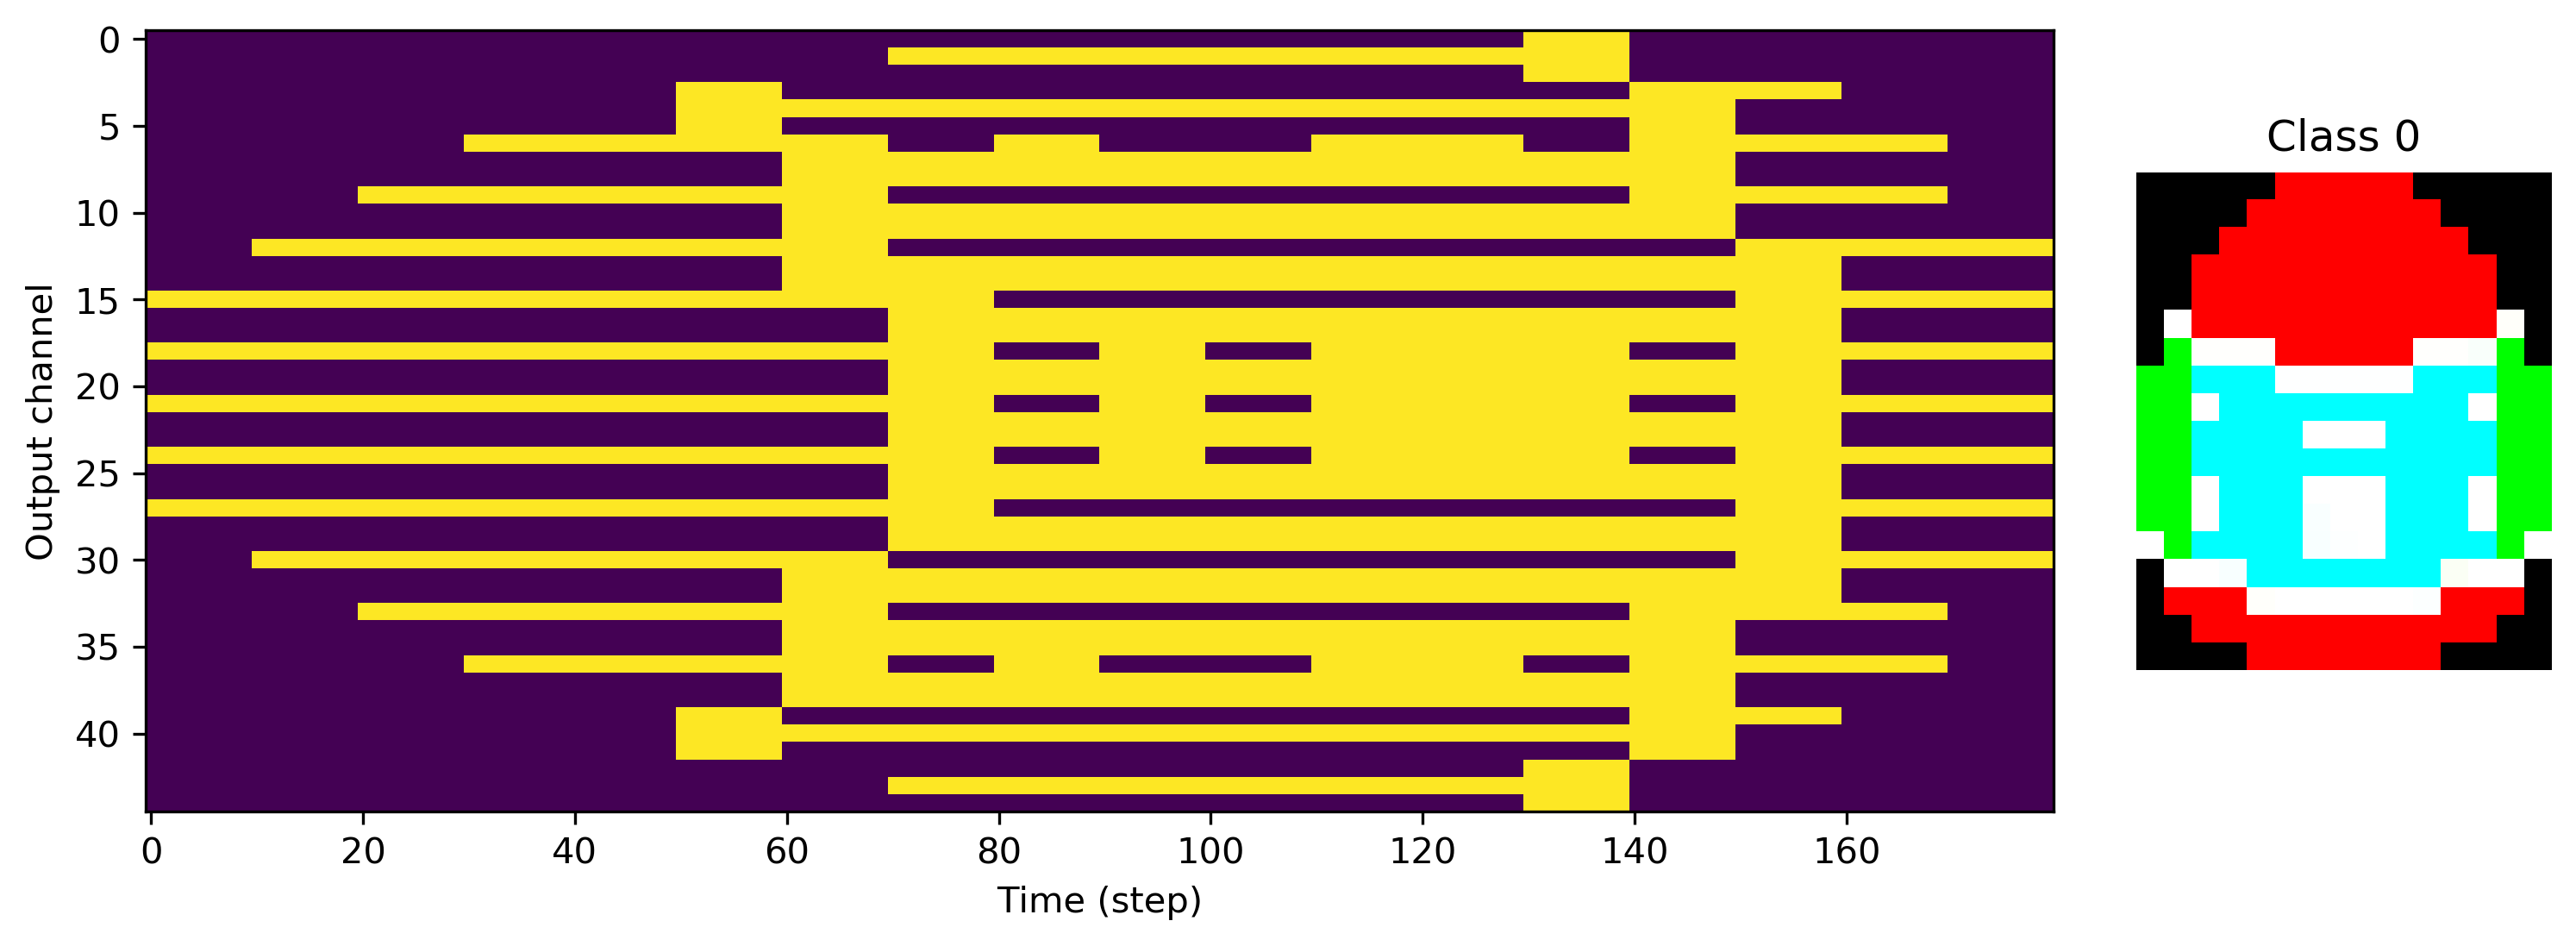

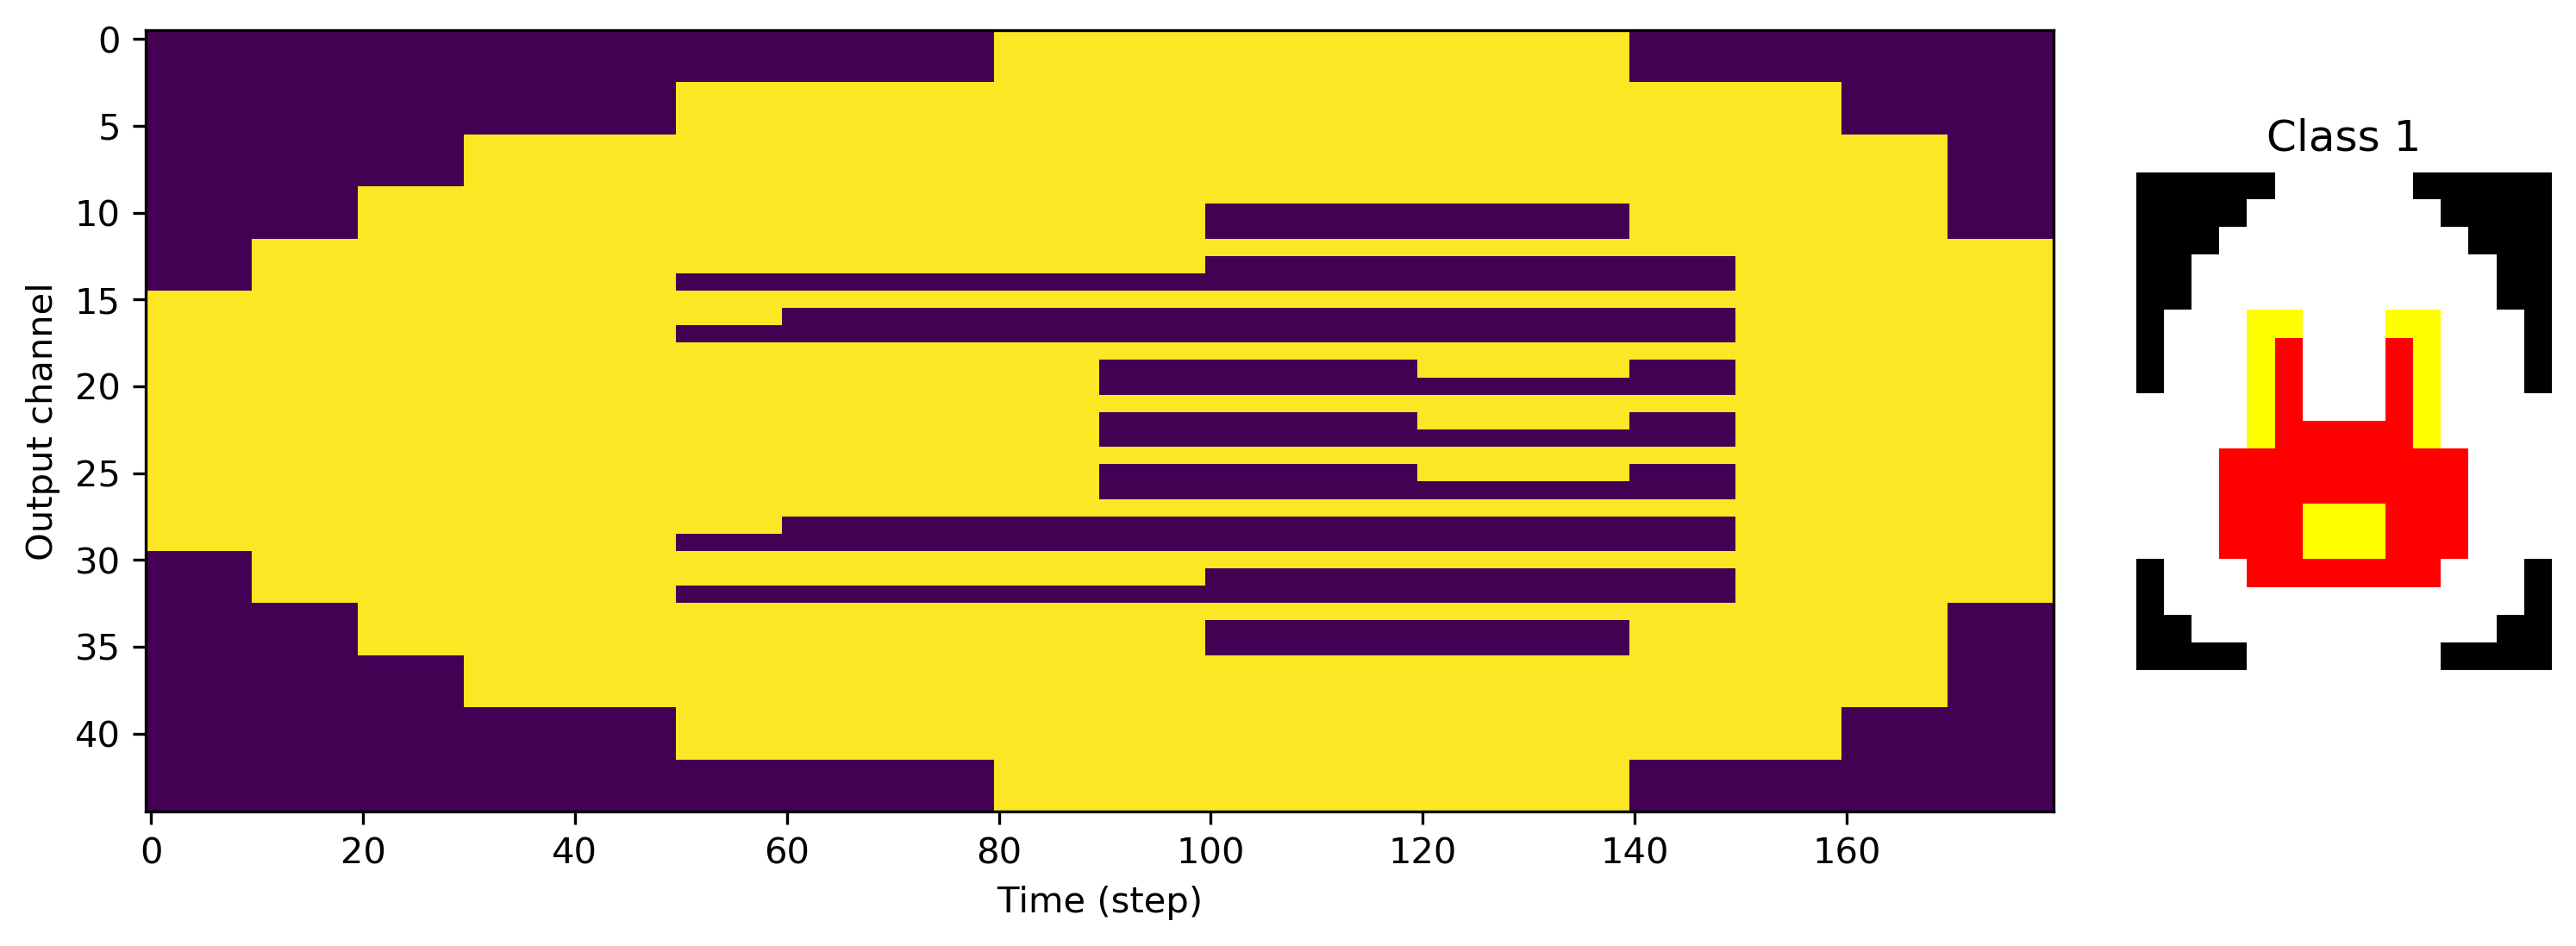

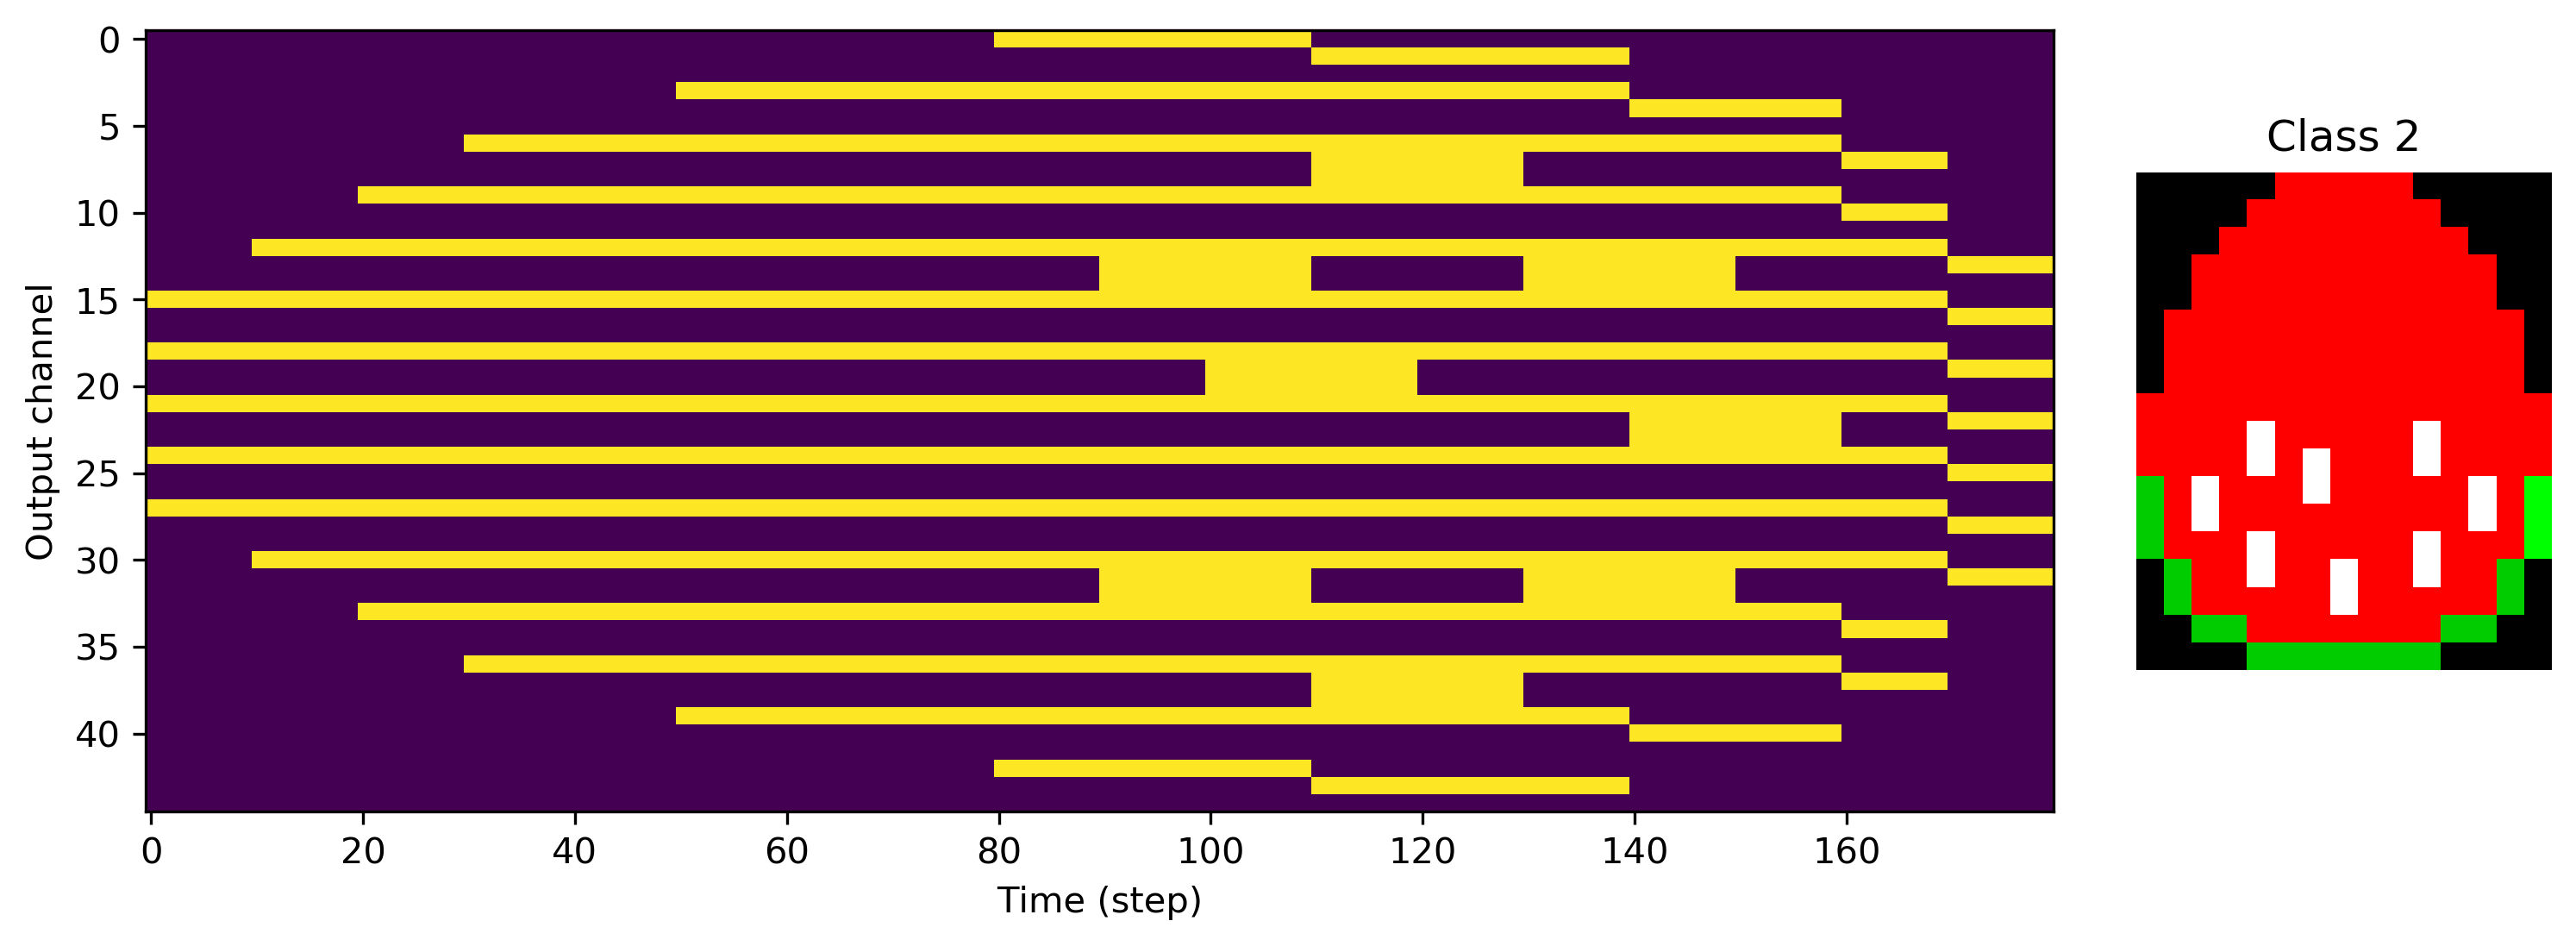

In [17]:
for class_index in range(len(ds)):
    plt.figure()
    plt.subplot(1, 5, (1, 4))
    plt.imshow(ds.target_raster[class_index].T, aspect='auto')
    plt.xlabel('Time (step)')
    plt.ylabel('Output channel')
    
    plt.subplot(1, 5, 5)
    plt.imshow(ds.images[class_index].astype('float'))
    plt.axis('off')
    plt.title(f'Class {class_index}')    

Now we need a network to train for this task. We'll use a simple feed-forward architecture with one hidden layer.

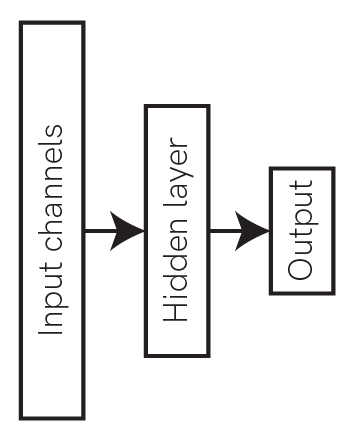

In [23]:
Image('network-01.png', width=200)

We'll use spiking linear integrate-and-fire (LIF) neurons for the hidden and output layers, using the Jax backend of Rockpool and the module `LIFJax`. This module provides a gradient-descent trainable layer of neurons, using Jax to optimise the neuron parameters. The weights in between the layers will use the `LinearJax` module, which is likewise trainable.

Let's pick 100 neurons for the hidden layer in this network.

In [24]:
# - Network configuration
Nin = ds.Nin
Nhidden = 100
Nout = ds.Nout

# - Rockpool modules
from rockpool.nn.modules import LIFJax, LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.training import jax_loss as jl

net = Sequential(
    LinearJax((Nin, Nhidden)),
    LIFJax((Nhidden)),
    LinearJax((Nhidden, Nout)),
    LIFJax((Nout))
)
print(net)

JaxSequential  with shape (1000, 45) {
    LinearJax '0_LinearJax' with shape (1000, 100)
    LIFJax '1_LIFJax' with shape (100,)
    LinearJax '2_LinearJax' with shape (100, 45)
    LIFJax '3_LIFJax' with shape (45,)
}


Now we can import Jax and build a simple loss function, which will be the MSE between the network output and the desired target. We use `jax.jit` to compile the optimiser update function as well as the loss function --- these will be automatically targeted to CPU, GPU or TPU by Jax, depending on what's available. We use `jax.value_and_grad` to automatically differentiate the loss function over the network parameters

In [25]:
# - Jax imports
import jax
from jax.experimental.optimizers import adam
from itertools import count

# - Initialise optimiser
learning_rate = 1e-5
init_fun, update_fun, get_params = adam(learning_rate)
opt_state = init_fun(net.parameters())
update_fun = jax.jit(update_fun)

# - Loss function
@jax.jit
@jax.value_and_grad
def loss_vgf(params, net, input, target):
    net = net.set_attributes(params)
    output, _, _ = net(input)
    return jl.mse(output, target)

Now we can specify the number of epochs to train for, and use a simple training loop to perform gradient descent learning. We'll keep track of the loss values along the way to visualise.

In [26]:
# - Configure learning
num_epochs = 25000

# - Training loop
loss_t = []
sample_index = count()
for epoch in trange(num_epochs):
    # - Loop over samples
    for this_input, this_target in ds:
        # - Get parameters
        opt_parameters = get_params(opt_state)

        # - Compute loss and gradient
        l, g = loss_vgf(opt_parameters, net, this_input, this_target)
        loss_t.append(l)
        
        # - Update optimiser
        opt_state = update_fun(next(sample_index), g, opt_state)

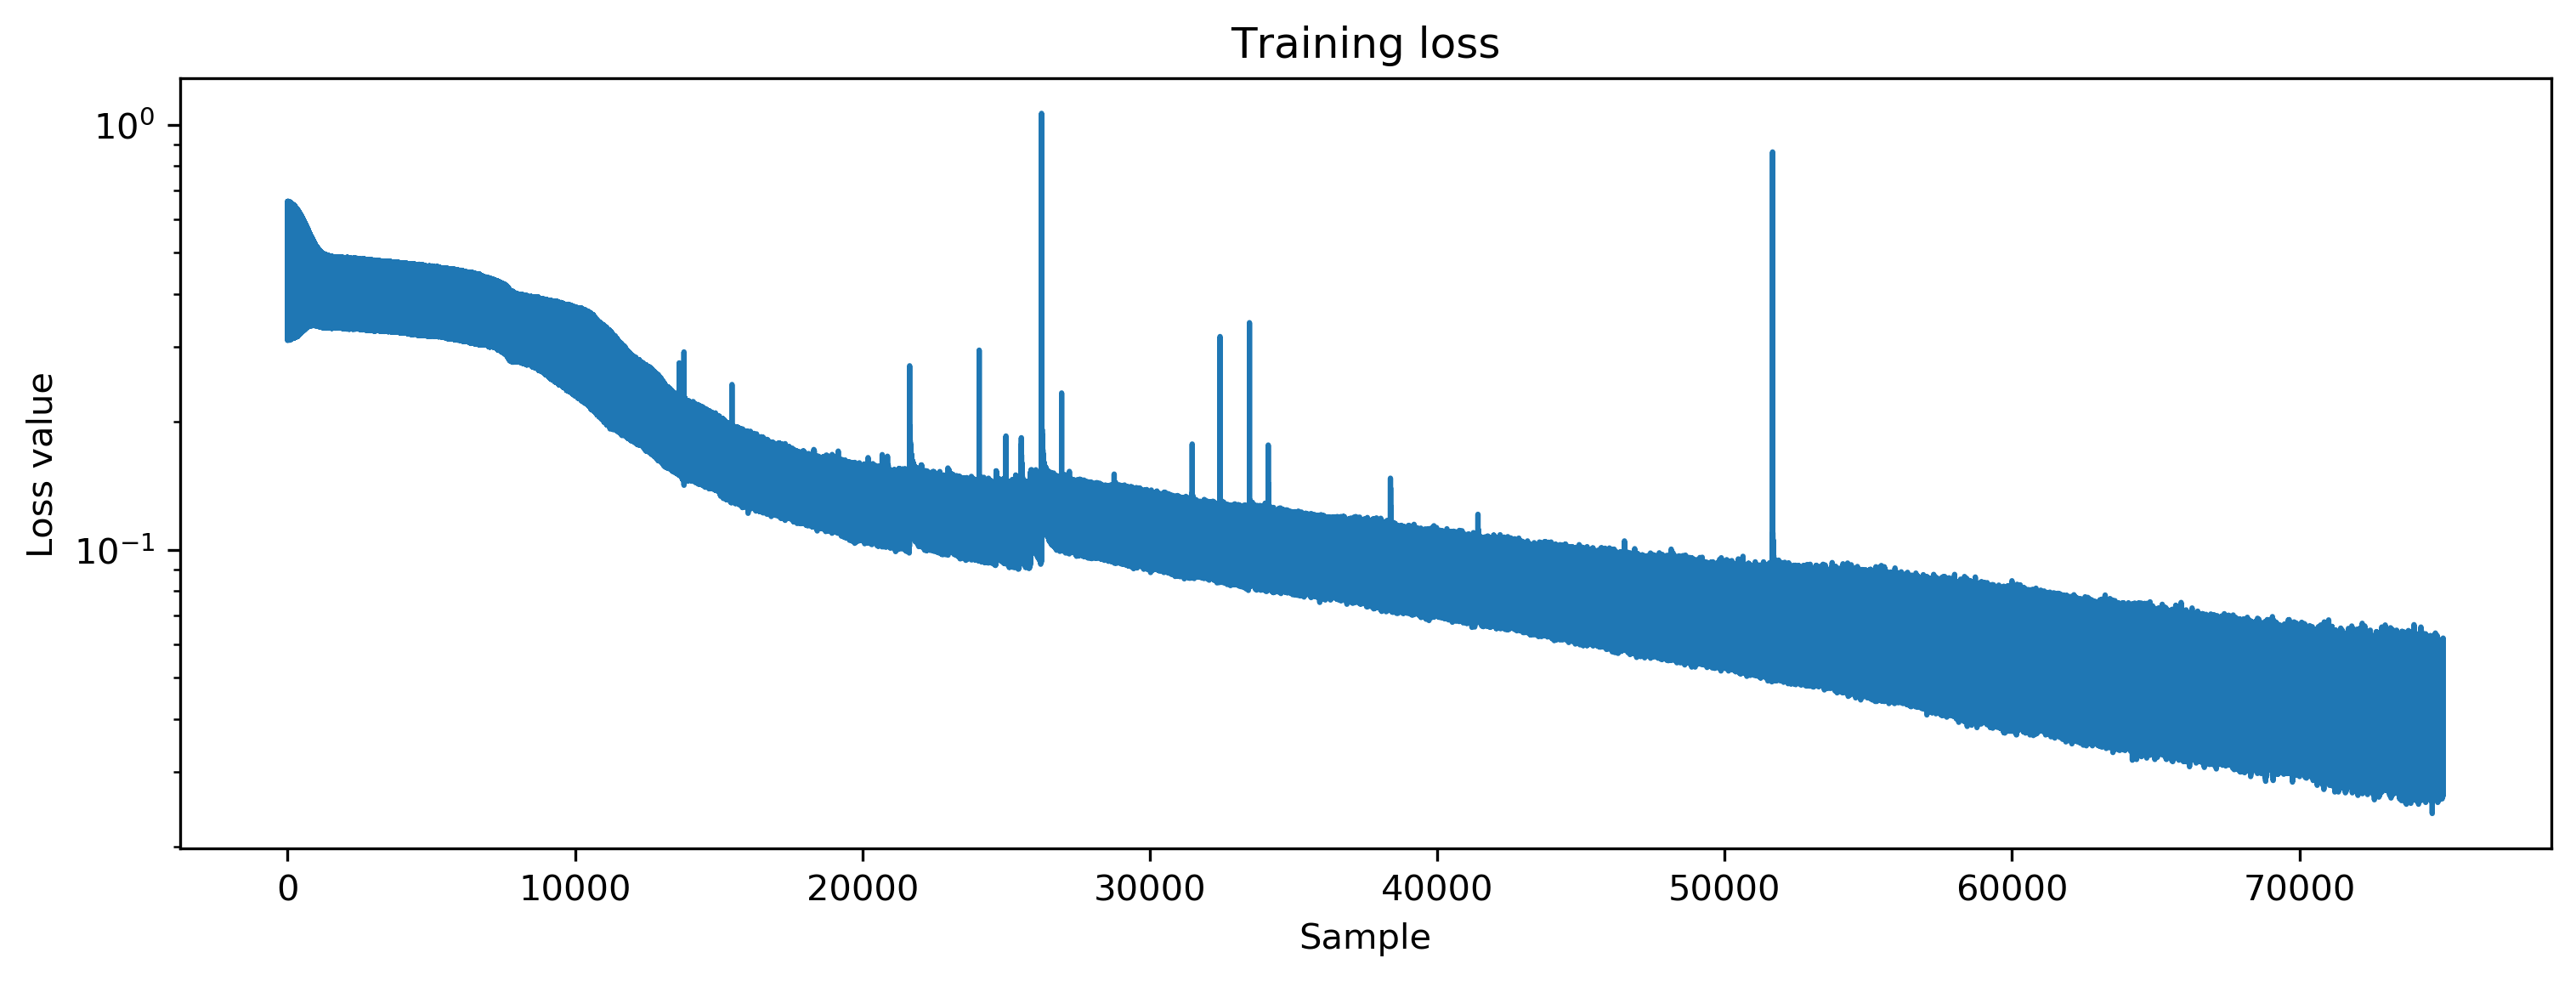

In [27]:
plt.plot(loss_t)
plt.yscale('log')
plt.xlabel('Sample')
plt.ylabel('Loss value')
plt.title('Training loss');

The loss decreased, indicating that the network is learning to produce the desired output. Let's visualise the output of the network over the various classes to check.

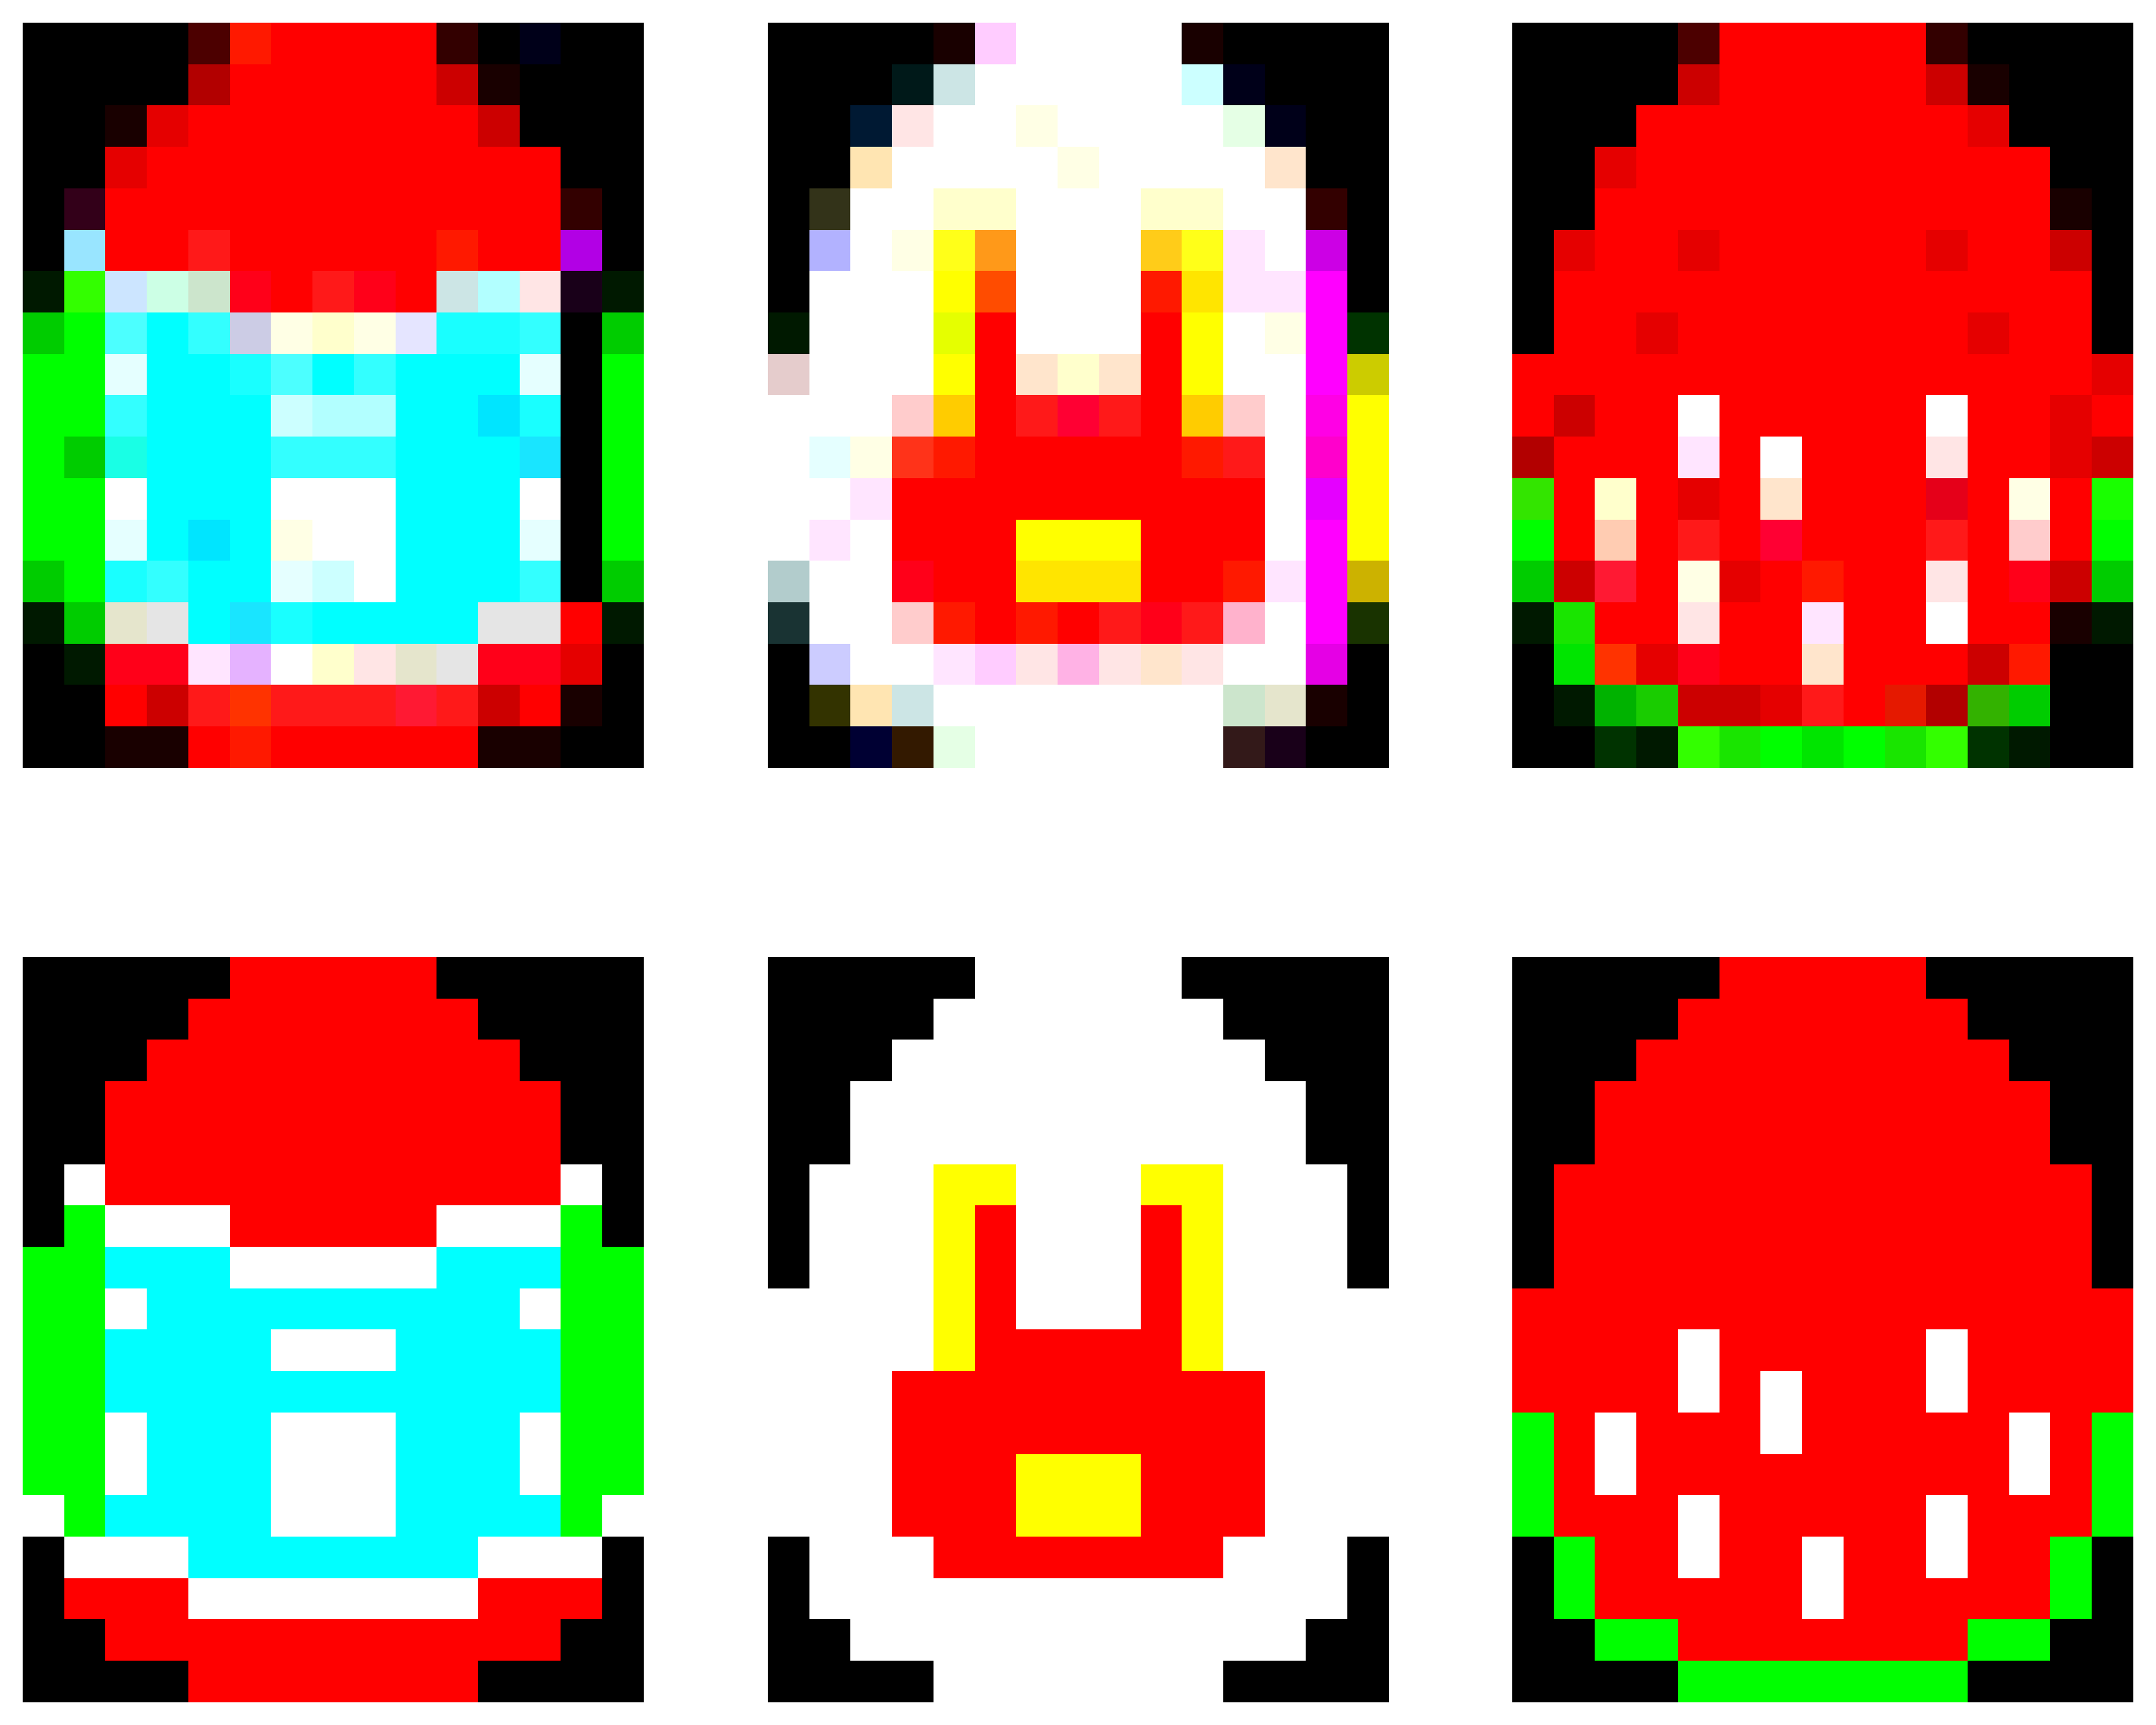

In [28]:
# - Test training
net = net.set_attributes(get_params(opt_state))

plt.figure(figsize=(12, 10))

for class_index in range(len(ds)):
    inp, target = ds[class_index]
    out, _, rec_state = net(inp)

    plt.subplot(2, 3, 1 + class_index)
    plt.imshow(ds.decode(out, class_index))
    plt.axis('off')

    plt.subplot(2, 3, 4 + class_index)
    plt.imshow(ds.decode(target, class_index))
    plt.axis('off')
    plt.axis('off')

But what is the network doing internally? Let's take a look at the spiking activity of the hidden and output layers.

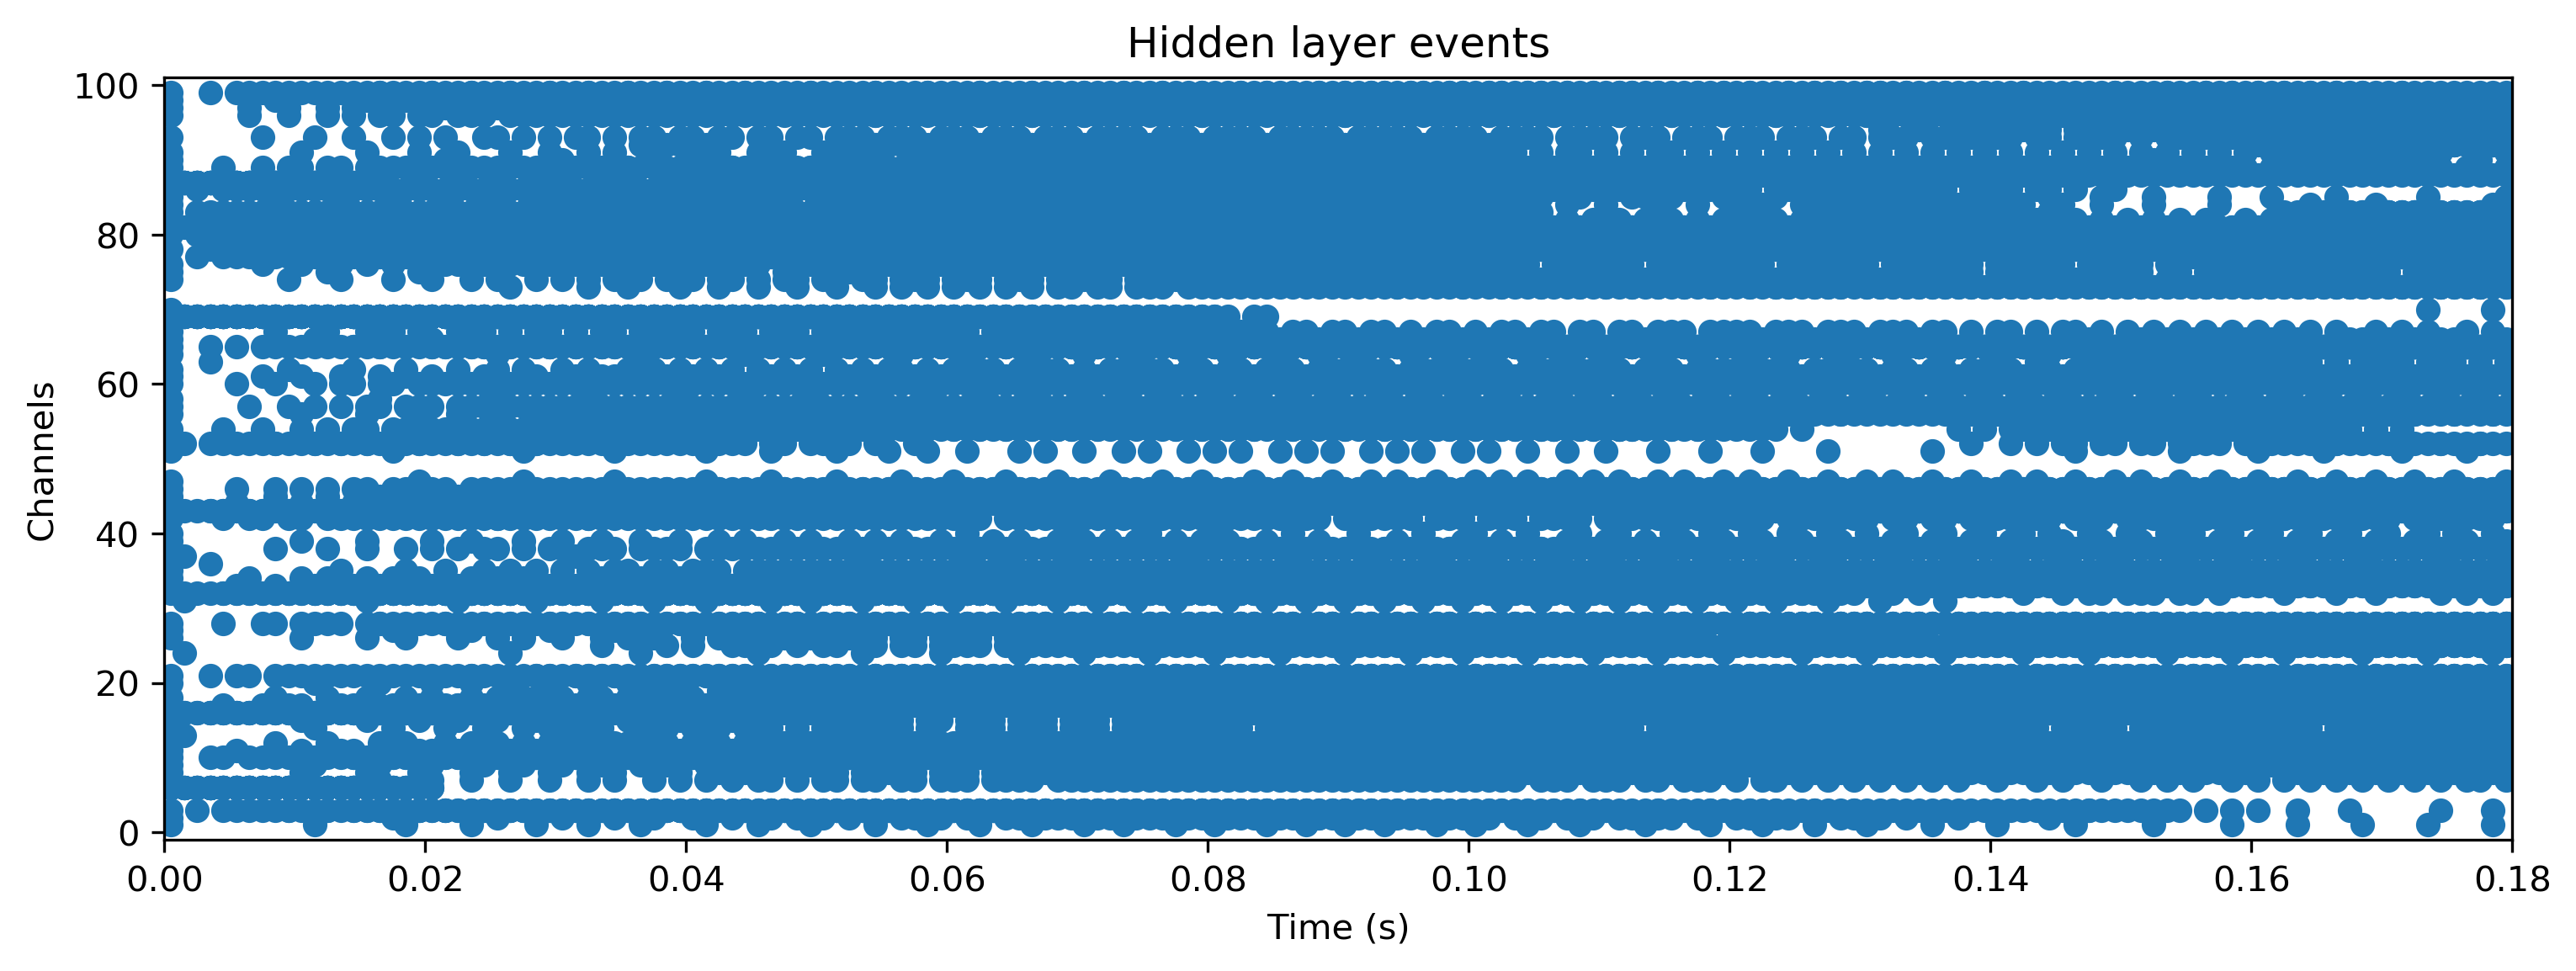

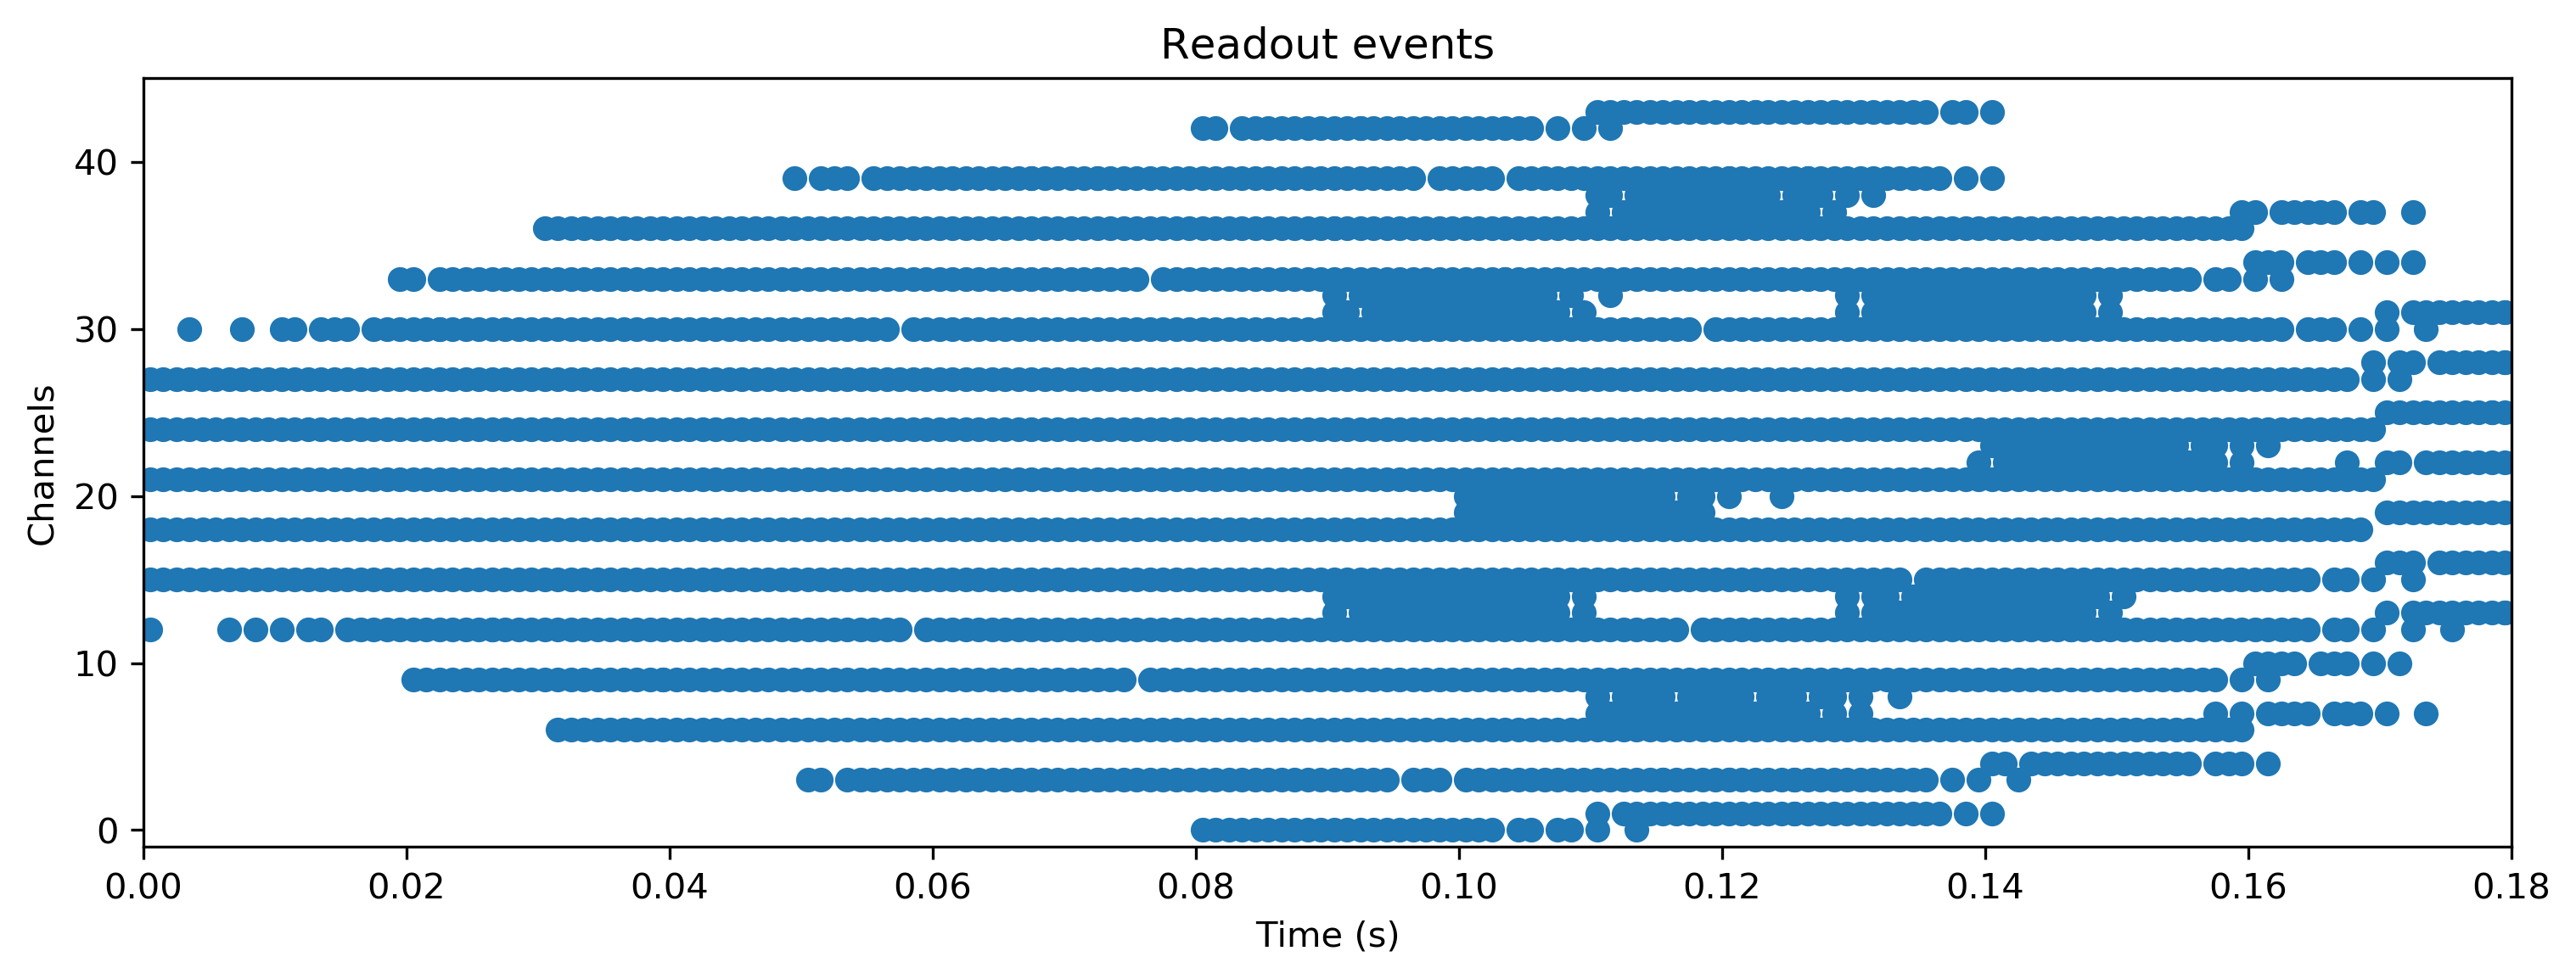

In [29]:
plt.figure()
TSEvent.from_raster(rec_state['1_LIFJax_output'], dt = 1e-3).plot();
plt.title('Hidden layer events')

plt.figure()
TSEvent.from_raster(rec_state['3_LIFJax_output'], dt = 1e-3).plot();
plt.title('Readout events');

This toolchain lets you train all neuron parameters, not only weights and biases. Let's take a look at the final distribution of time constants, which were initially identical.

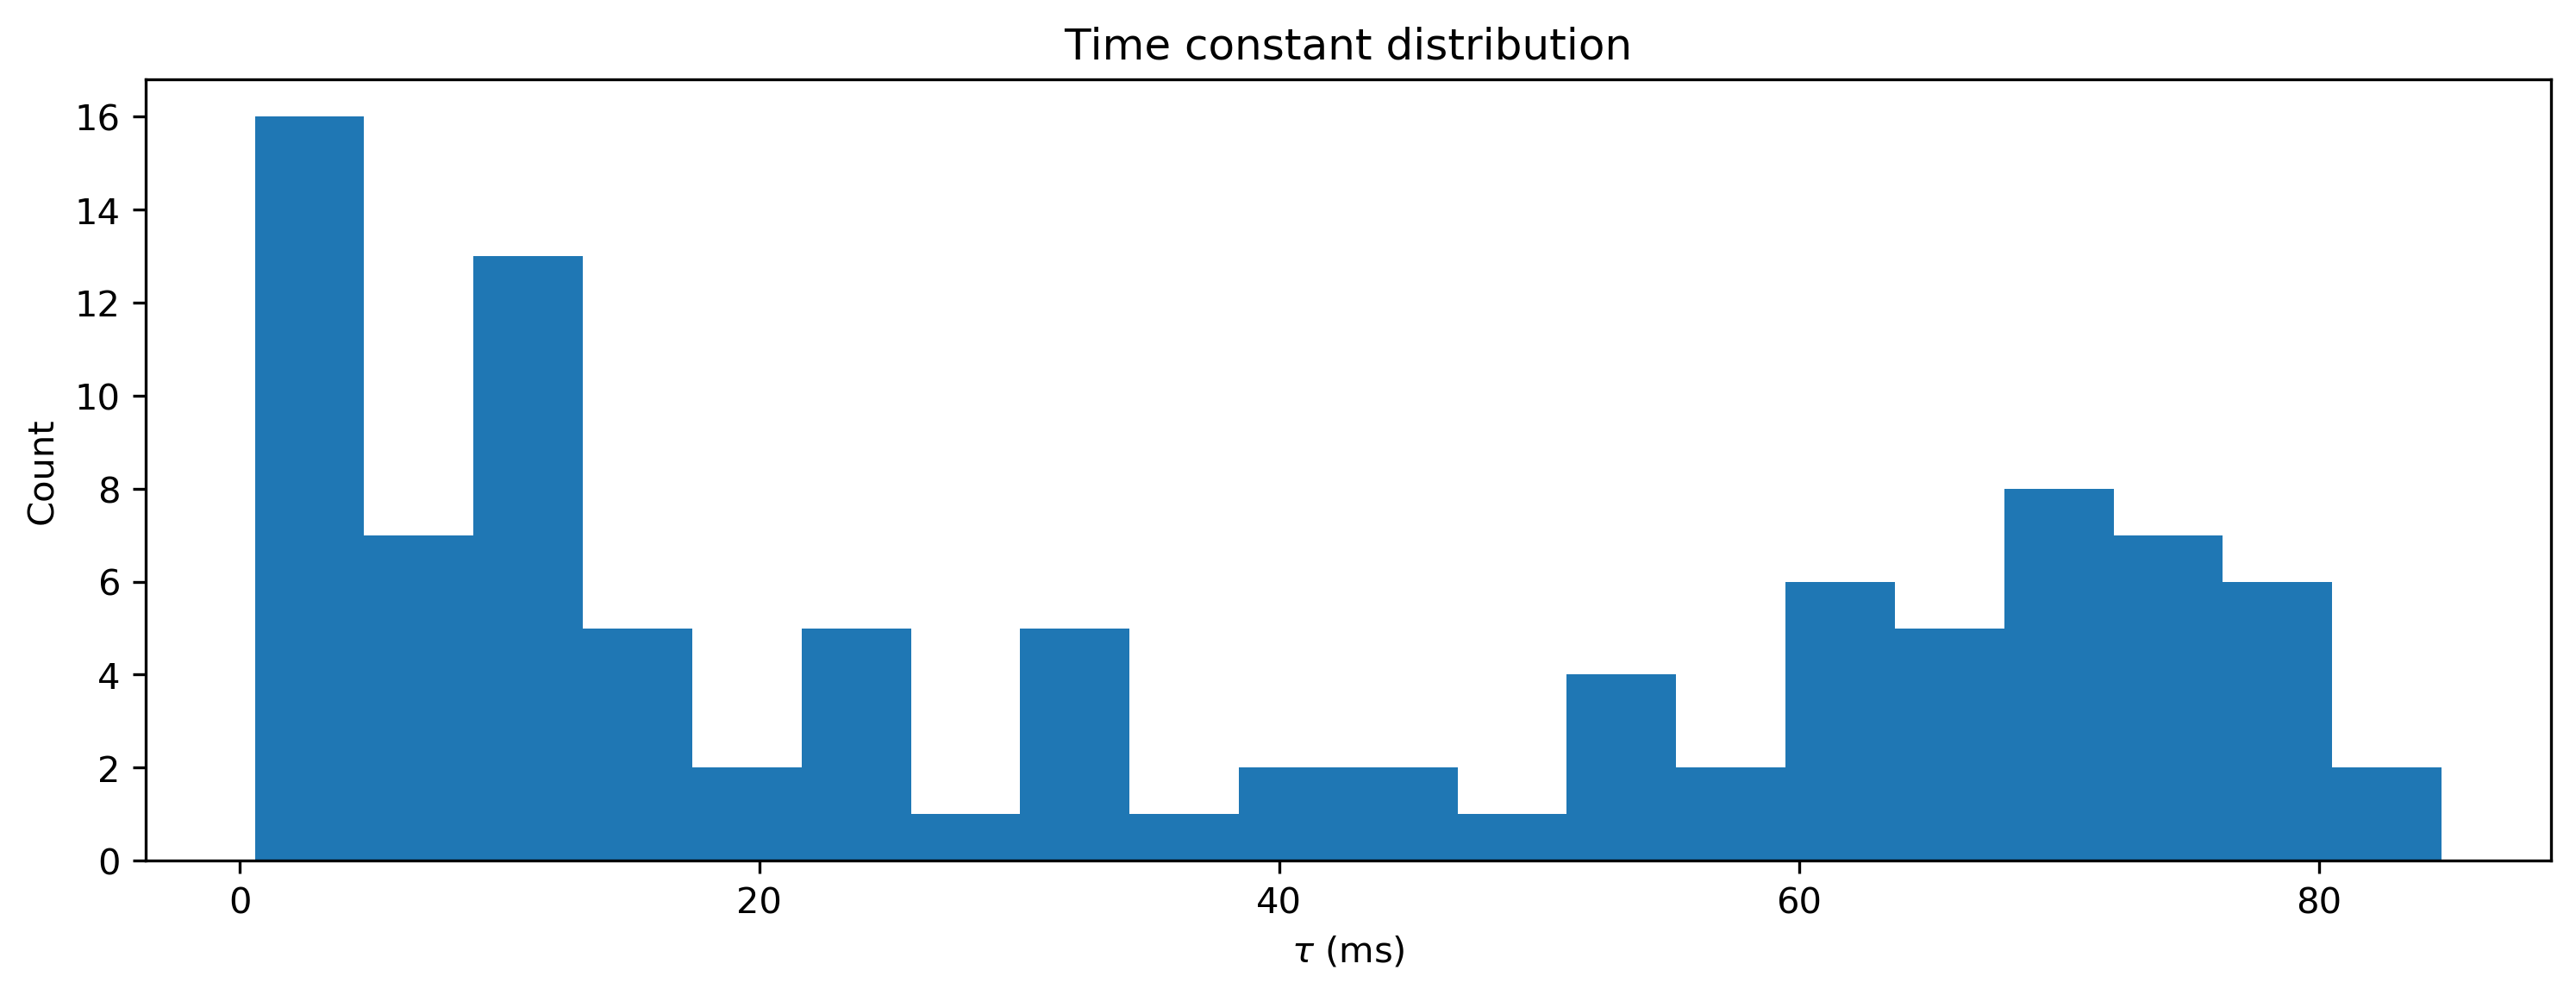

In [30]:
plt.hist(net[1].tau_mem * 1e3, 20)
plt.xlabel('$\\tau$ (ms)')
plt.ylabel('Count')
plt.title('Time constant distribution');

And of course the weights have also been learned to perform the task correctly.

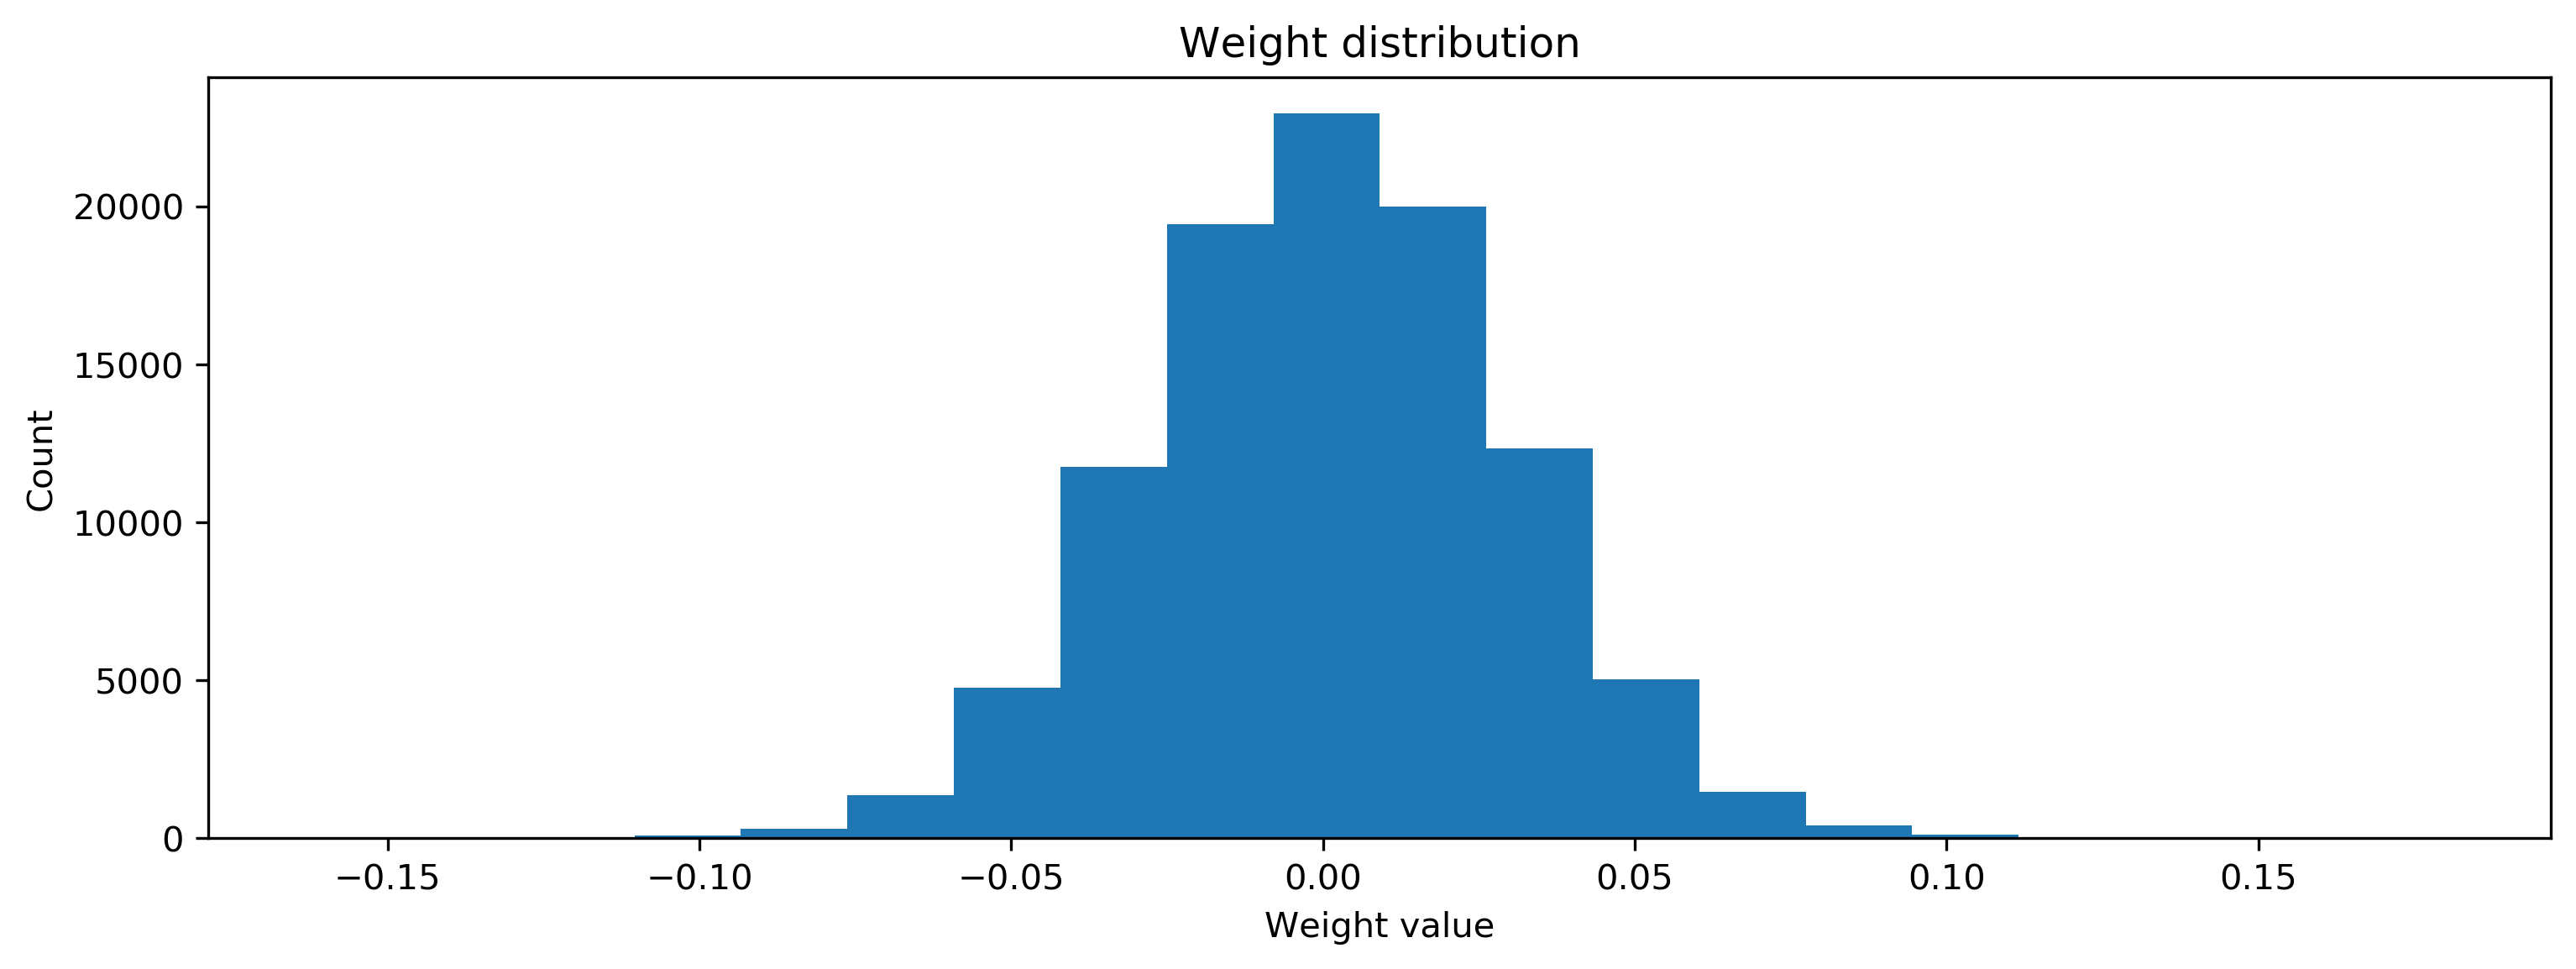

In [31]:
plt.hist(np.ravel(net[0].weight), 20)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Weight distribution');

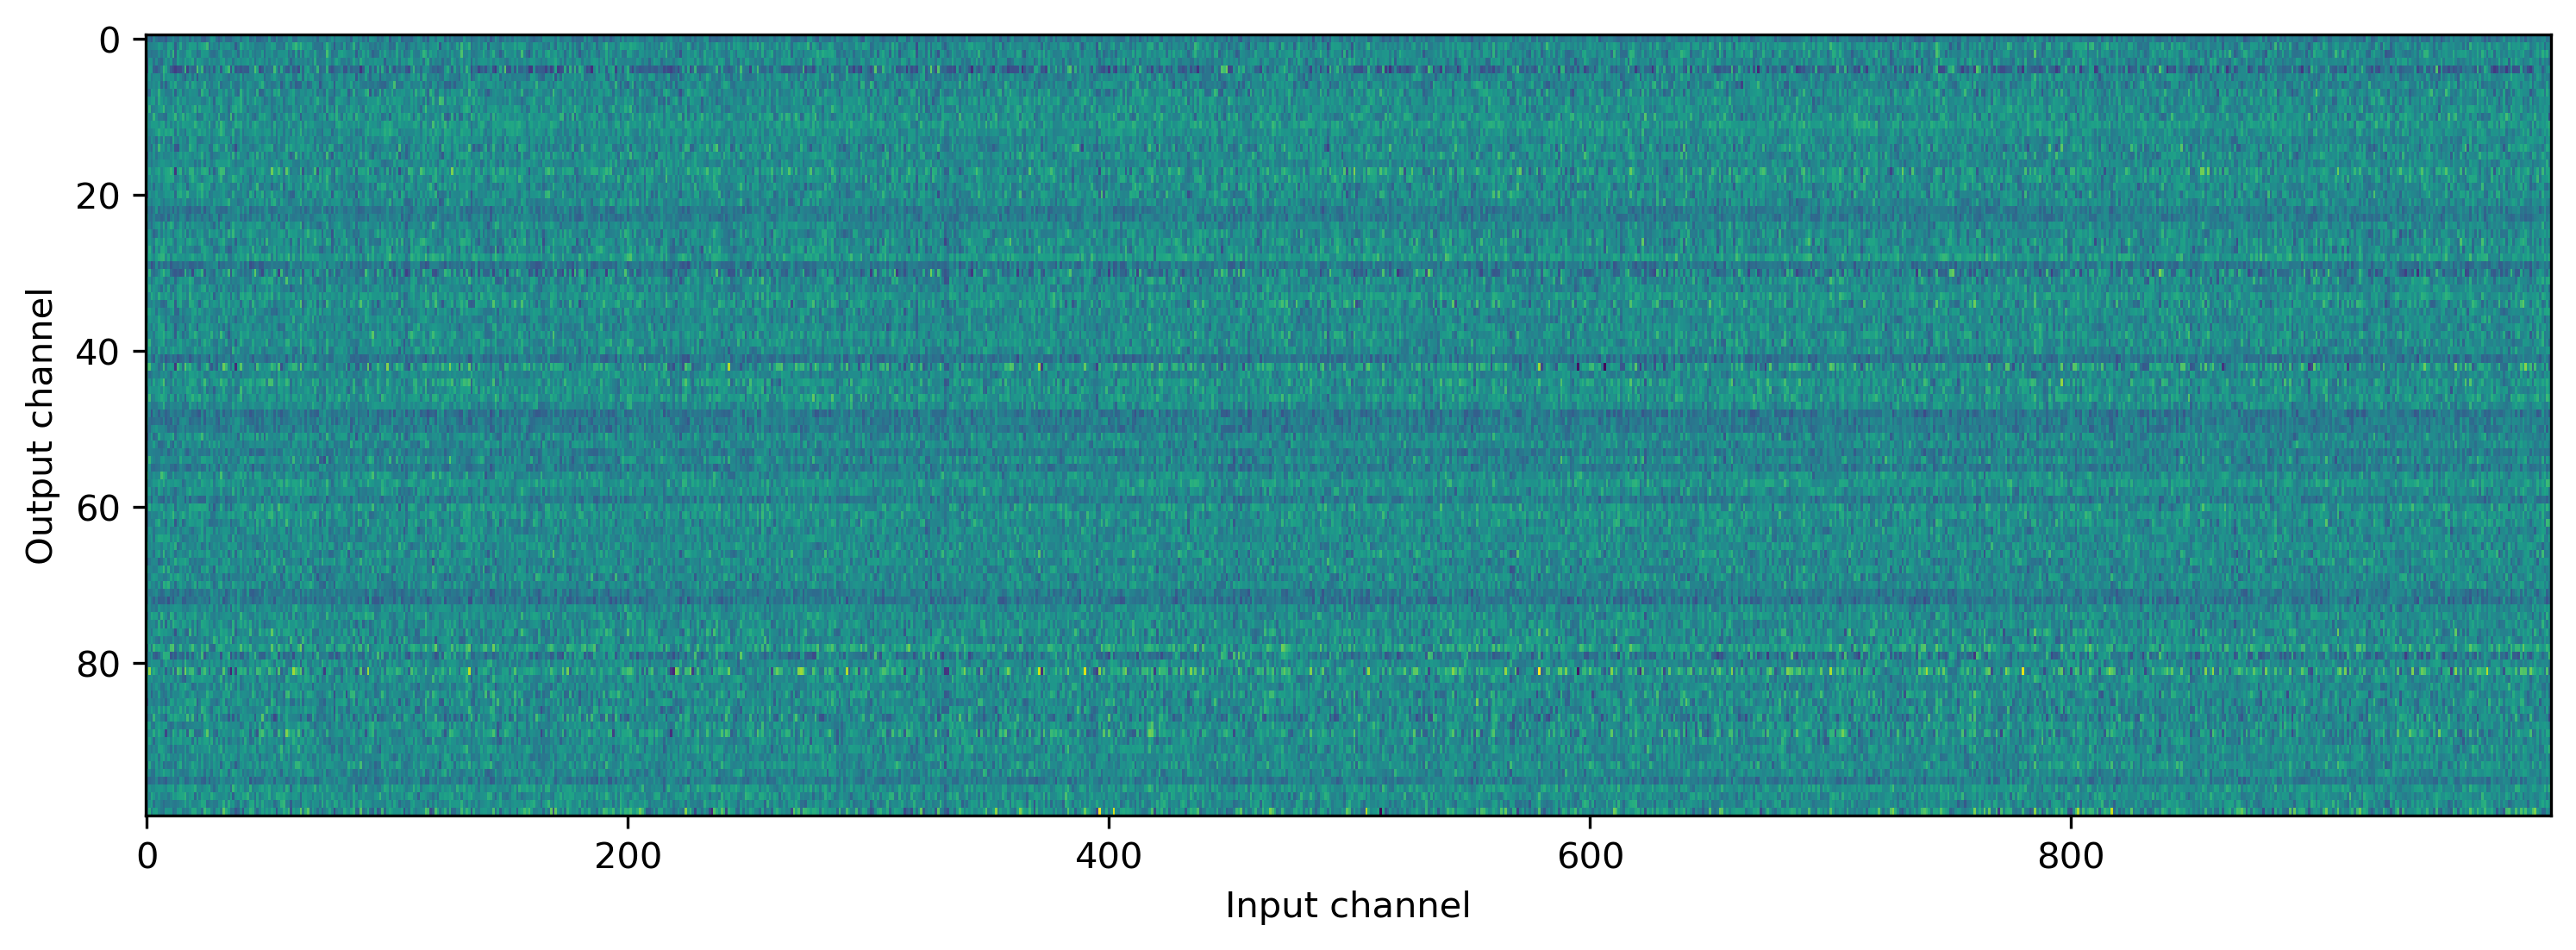

In [32]:
plt.imshow(net[0].weight.T, aspect='auto');
plt.xlabel('Input channel')
plt.ylabel('Output channel');